In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib
matplotlib.rcParams['font.family'] = 'STSong'
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models import LdaModel
from gensim.corpora import Dictionary
import jieba
import seaborn as sns
import pyLDAvis.gensim
from pyecharts import options as opts
from pyecharts.charts import Pie
from pyecharts.globals import CurrentConfig, NotebookType, ThemeType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from snownlp import SnowNLP
from collections import defaultdict
import stylecloud
from IPython.display import Image 
import warnings
warnings.filterwarnings('ignore')

D:\Program Files\Python3.10\lib\site-packages\joblib\backports.py:22: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils  # noqa


In [2]:
df = pd.read_csv('data/rumor_text_data.csv', parse_dates=['date'])
df.head(3)

,date,source,source_num,content,core,province,like,log_like,views
0,2022-02-18,北京日报客户端,1,“有人从香港游泳偷渡到深圳湾被捕？”假的！系轻生被救！,有人从香港游泳偷渡到深圳湾被捕？,广东省,0,0.000000,0
1,2022-02-18,大河报、羊城晚报,2,近日，社交媒体上一则题为“河南一位老爷爷考上清华大学被顶替”的消息引发网友关注和转发。消息称...,河南一位老爷爷考上清华大学被顶替,河南省,41,3.737670,1
2,2022-02-17,南方都市报、大众网,2,近日，网传“湖南衡阳南岳衡山寺庙高薪招聘住持，月薪高达5万元，弹性工作制，下班后原则上不干预...,湖南衡阳南岳衡山寺庙高薪招聘住持，月薪高达5万元，弹性工作制，下班后原则上不干预私生活,湖南省,26,3.295837,1


# 2 文本主题挖掘与情感分析

content列的谣言信息虽然全面但冗余信息较多，可以用于区分大标题；而core列的谣言信息更加精准简洁，可以用于区分小标题。

## 2.1 利用content列建立LDA模型

获取谣言信息的文本列表。

In [3]:
corpus = list(df.content)

读取停用词文件。

In [4]:
with open('LDA/stopwords_all.txt', 'r') as f:
    stopwords = [line.strip() for line in f]
num_words = [str(i) for i in range(3000)]
stopwords = stopwords + num_words

获取除去停用词后的tokens列表。

In [5]:
tokenlist = [jieba.lcut(text, HMM=True) for text in corpus]
tokenlist = [[t for t in tokens if t not in stopwords] for tokens in tokenlist]

Building prefix dict from the default dictionary ...
Loading model from cache D:\Temp\jieba.cache
Loading model cost 0.309 seconds.
Prefix dict has been built successfully.


创建tokens字典。

In [6]:
dictionary = corpora.Dictionary(tokenlist)

创建bag of words列表。

In [7]:
bow = [dictionary.doc2bow(text) for text in tokenlist]

拟合LDA模型，主题定为6个，训练100轮。

In [8]:
num_topics = 6
# lda = LdaModel(corpus=bow, id2word=dictionary, num_topics=num_topics, passes=100)

保存LDA模型（这里为了可重复性，直接载入我已经训练好的模型）。

In [9]:
# lda.save('LDA/LdaModel6')
lda = LdaModel.load('LDA/LdaModel6')

用pyLDAvis可视化文本主题挖掘模型。

In [10]:
# d = pyLDAvis.gensim.prepare(lda, bow, dictionary)
# pyLDAvis.save_html(d, 'LDA/LdaModel_visulization_all6.html')

查看所有topic中词的probability最高的前5个。

In [11]:
for topic in lda.print_topics(num_words = 5):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('   ', listItems[1].replace(' ', ''), ' (', listItems[0].replace(' ', ''), ')', sep='')

0:
   "检测" (0.016)
   "核酸" (0.014)
   "疫情" (0.007)
   "平台" (0.006)
   "快递" (0.006)
1:
   "警方" (0.005)
   "平台" (0.005)
   "短信" (0.004)
   "发生" (0.004)
   "部门" (0.004)
2:
   "确诊" (0.018)
   "病例" (0.018)
   "疫情" (0.016)
   "新冠" (0.012)
   "防控" (0.011)
3:
   "平台" (0.007)
   "虚假" (0.005)
   "警方" (0.005)
   "有人" (0.004)
   "地铁" (0.004)
4:
   "活动" (0.005)
   "学校" (0.004)
   "甲醛" (0.004)
   "高速" (0.004)
   "上海" (0.004)
5:
   "通知" (0.005)
   "北京" (0.005)
   "吃" (0.004)
   "贷款" (0.003)
   "时间" (0.003)


获取每条消息对应的topic和概率。

In [12]:
document_topics = lda.get_document_topics(bow)
topic_list = []
prob_list = []
for topics in document_topics:
    if len(topics) > 1:
        max_prob = 0
        for i, topic in enumerate(topics):
            if topic[1] > max_prob:
                best_topic = i
                max_prob = topic[1]
    else:
        best_topic = topics[0][0]
        max_prob = topics[0][1]
    topic_list.append(best_topic)
    prob_list.append(max_prob)
    print(f'Topic: {best_topic}, Probability: {max_prob:.2f}')

Topic: 4, Probability: 0.92
Topic: 3, Probability: 0.99
Topic: 3, Probability: 0.98
Topic: 2, Probability: 0.98
Topic: 4, Probability: 0.93
Topic: 4, Probability: 0.97
Topic: 3, Probability: 0.99
Topic: 2, Probability: 0.92
Topic: 3, Probability: 0.99
Topic: 4, Probability: 0.99
Topic: 0, Probability: 0.96
Topic: 1, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 2, Probability: 0.98
Topic: 1, Probability: 0.97
Topic: 2, Probability: 0.98
Topic: 3, Probability: 0.97
Topic: 0, Probability: 0.78
Topic: 4, Probability: 0.97
Topic: 1, Probability: 0.96
Topic: 2, Probability: 0.74
Topic: 0, Probability: 0.99
Topic: 2, Probability: 0.98
Topic: 1, Probability: 0.59
Topic: 2, Probability: 0.99
Topic: 2, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 0, Probability: 0.98
Topic: 1, Probability: 0.65
Topic: 1, Probability: 0.99
Topic: 4, Probability: 0.99
Topic: 1, Probability: 0.98
Topic: 2, Probability: 0.98
Topic: 0, Probability: 0.99
Topic: 1, Probabilit

Topic: 0, Probability: 0.99
Topic: 0, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 0, Probability: 0.98
Topic: 5, Probability: 1.00
Topic: 5, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 1, Probability: 0.79
Topic: 1, Probability: 0.95
Topic: 5, Probability: 1.00
Topic: 0, Probability: 0.99
Topic: 4, Probability: 0.99
Topic: 4, Probability: 0.99
Topic: 5, Probability: 0.99
Topic: 1, Probability: 0.99
Topic: 1, Probability: 0.98
Topic: 1, Probability: 0.99
Topic: 0, Probability: 0.99
Topic: 1, Probability: 0.99
Topic: 5, Probability: 0.97
Topic: 3, Probability: 0.97
Topic: 3, Probability: 0.98
Topic: 0, Probability: 0.99
Topic: 2, Probability: 0.95
Topic: 0, Probability: 0.50
Topic: 5, Probability: 0.99
Topic: 2, Probability: 0.98
Topic: 1, Probability: 0.97
Topic: 0, Probability: 0.99
Topic: 0, Probability: 0.98
Topic: 0, Probability: 0.89
Topic: 3, Probability: 0.98
Topic: 2, Probability: 0.98
Topic: 3, Probability: 0.98
Topic: 0, Probability: 0.98
Topic: 2, Probabilit

将topic和相应概率保存到数据中。

In [13]:
df['all_topic'] = topic_list
df['all_prob'] = prob_list

In [14]:
lda.show_topic(1) # 根据主题找对应频率最高的词（中文对应）
lda.get_topic_terms(0, topn=10) # 根据主题找对应频率最高的词（词的id）

[(199, 0.015581866),
 (286, 0.01449636),
 (295, 0.00703691),
 (464, 0.0062852157),
 (696, 0.0061411965),
 (511, 0.00543034),
 (114, 0.00539393),
 (248, 0.0051672244),
 (2083, 0.00447511),
 (124, 0.003919754)]

查看模型各个主题之间的相似度。

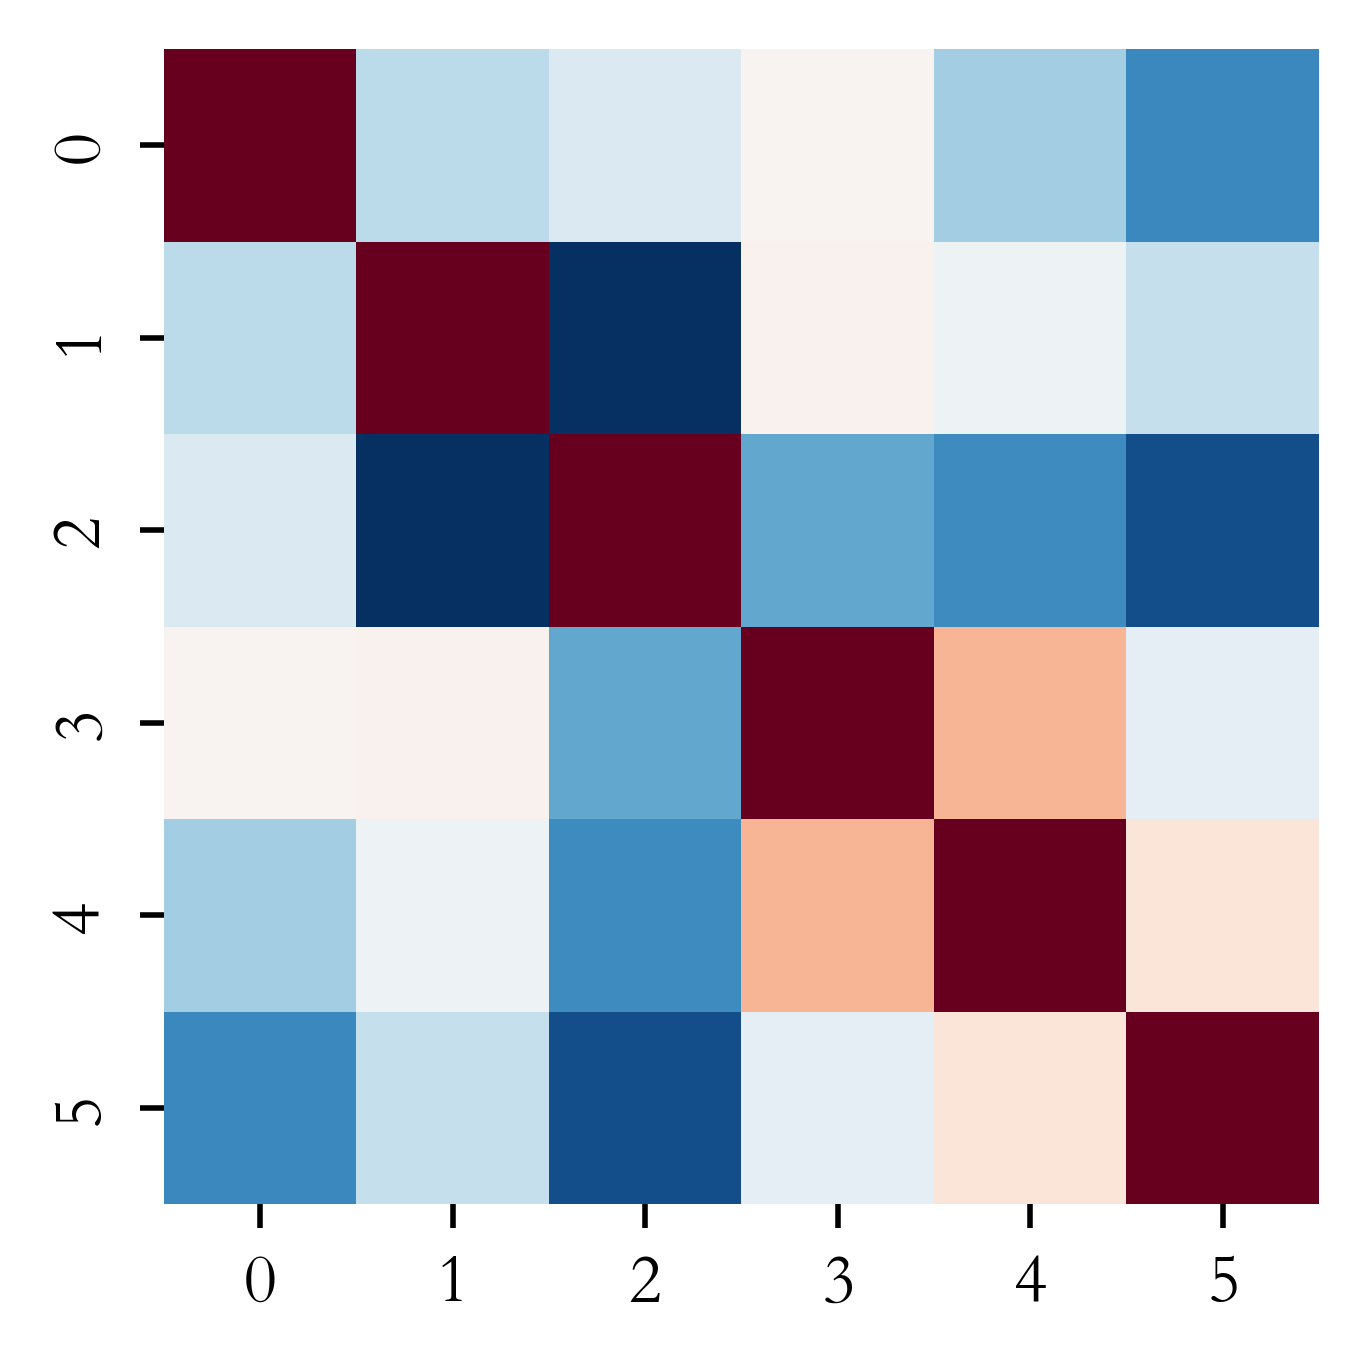

In [15]:
mdiff, annotation = lda.diff(lda, distance='hellinger', num_words=50)
plt.figure(figsize = (3, 3), dpi=500)
sns.heatmap(1 / (1 + mdiff), cbar=False, annot=False, square=True, fmt='.2f',
            # annot_kws={'size': 10}
            vmin=0.5, vmax=0.54, cmap='RdBu_r')
plt.show()

查看每个主题的word distribution。

In [16]:
lda_matrix = lda.get_topics()
word_dist = pd.DataFrame(np.zeros((num_topics * lda_matrix.shape[1], 3)))
word_dist.columns = ['word', 'topic', 'probability']
word_dist['word'] = list(range(lda_matrix.shape[1])) * num_topics
word_dist['topic'] = np.concatenate([[i] * lda_matrix.shape[1] for i in range(num_topics)])
word_dist['probability'] = np.concatenate(lda_matrix)
word_dist.head()

,word,topic,probability
0,0,0,0.000031
1,1,0,0.000031
2,2,0,0.000031
3,3,0,0.002733
4,4,0,0.000031


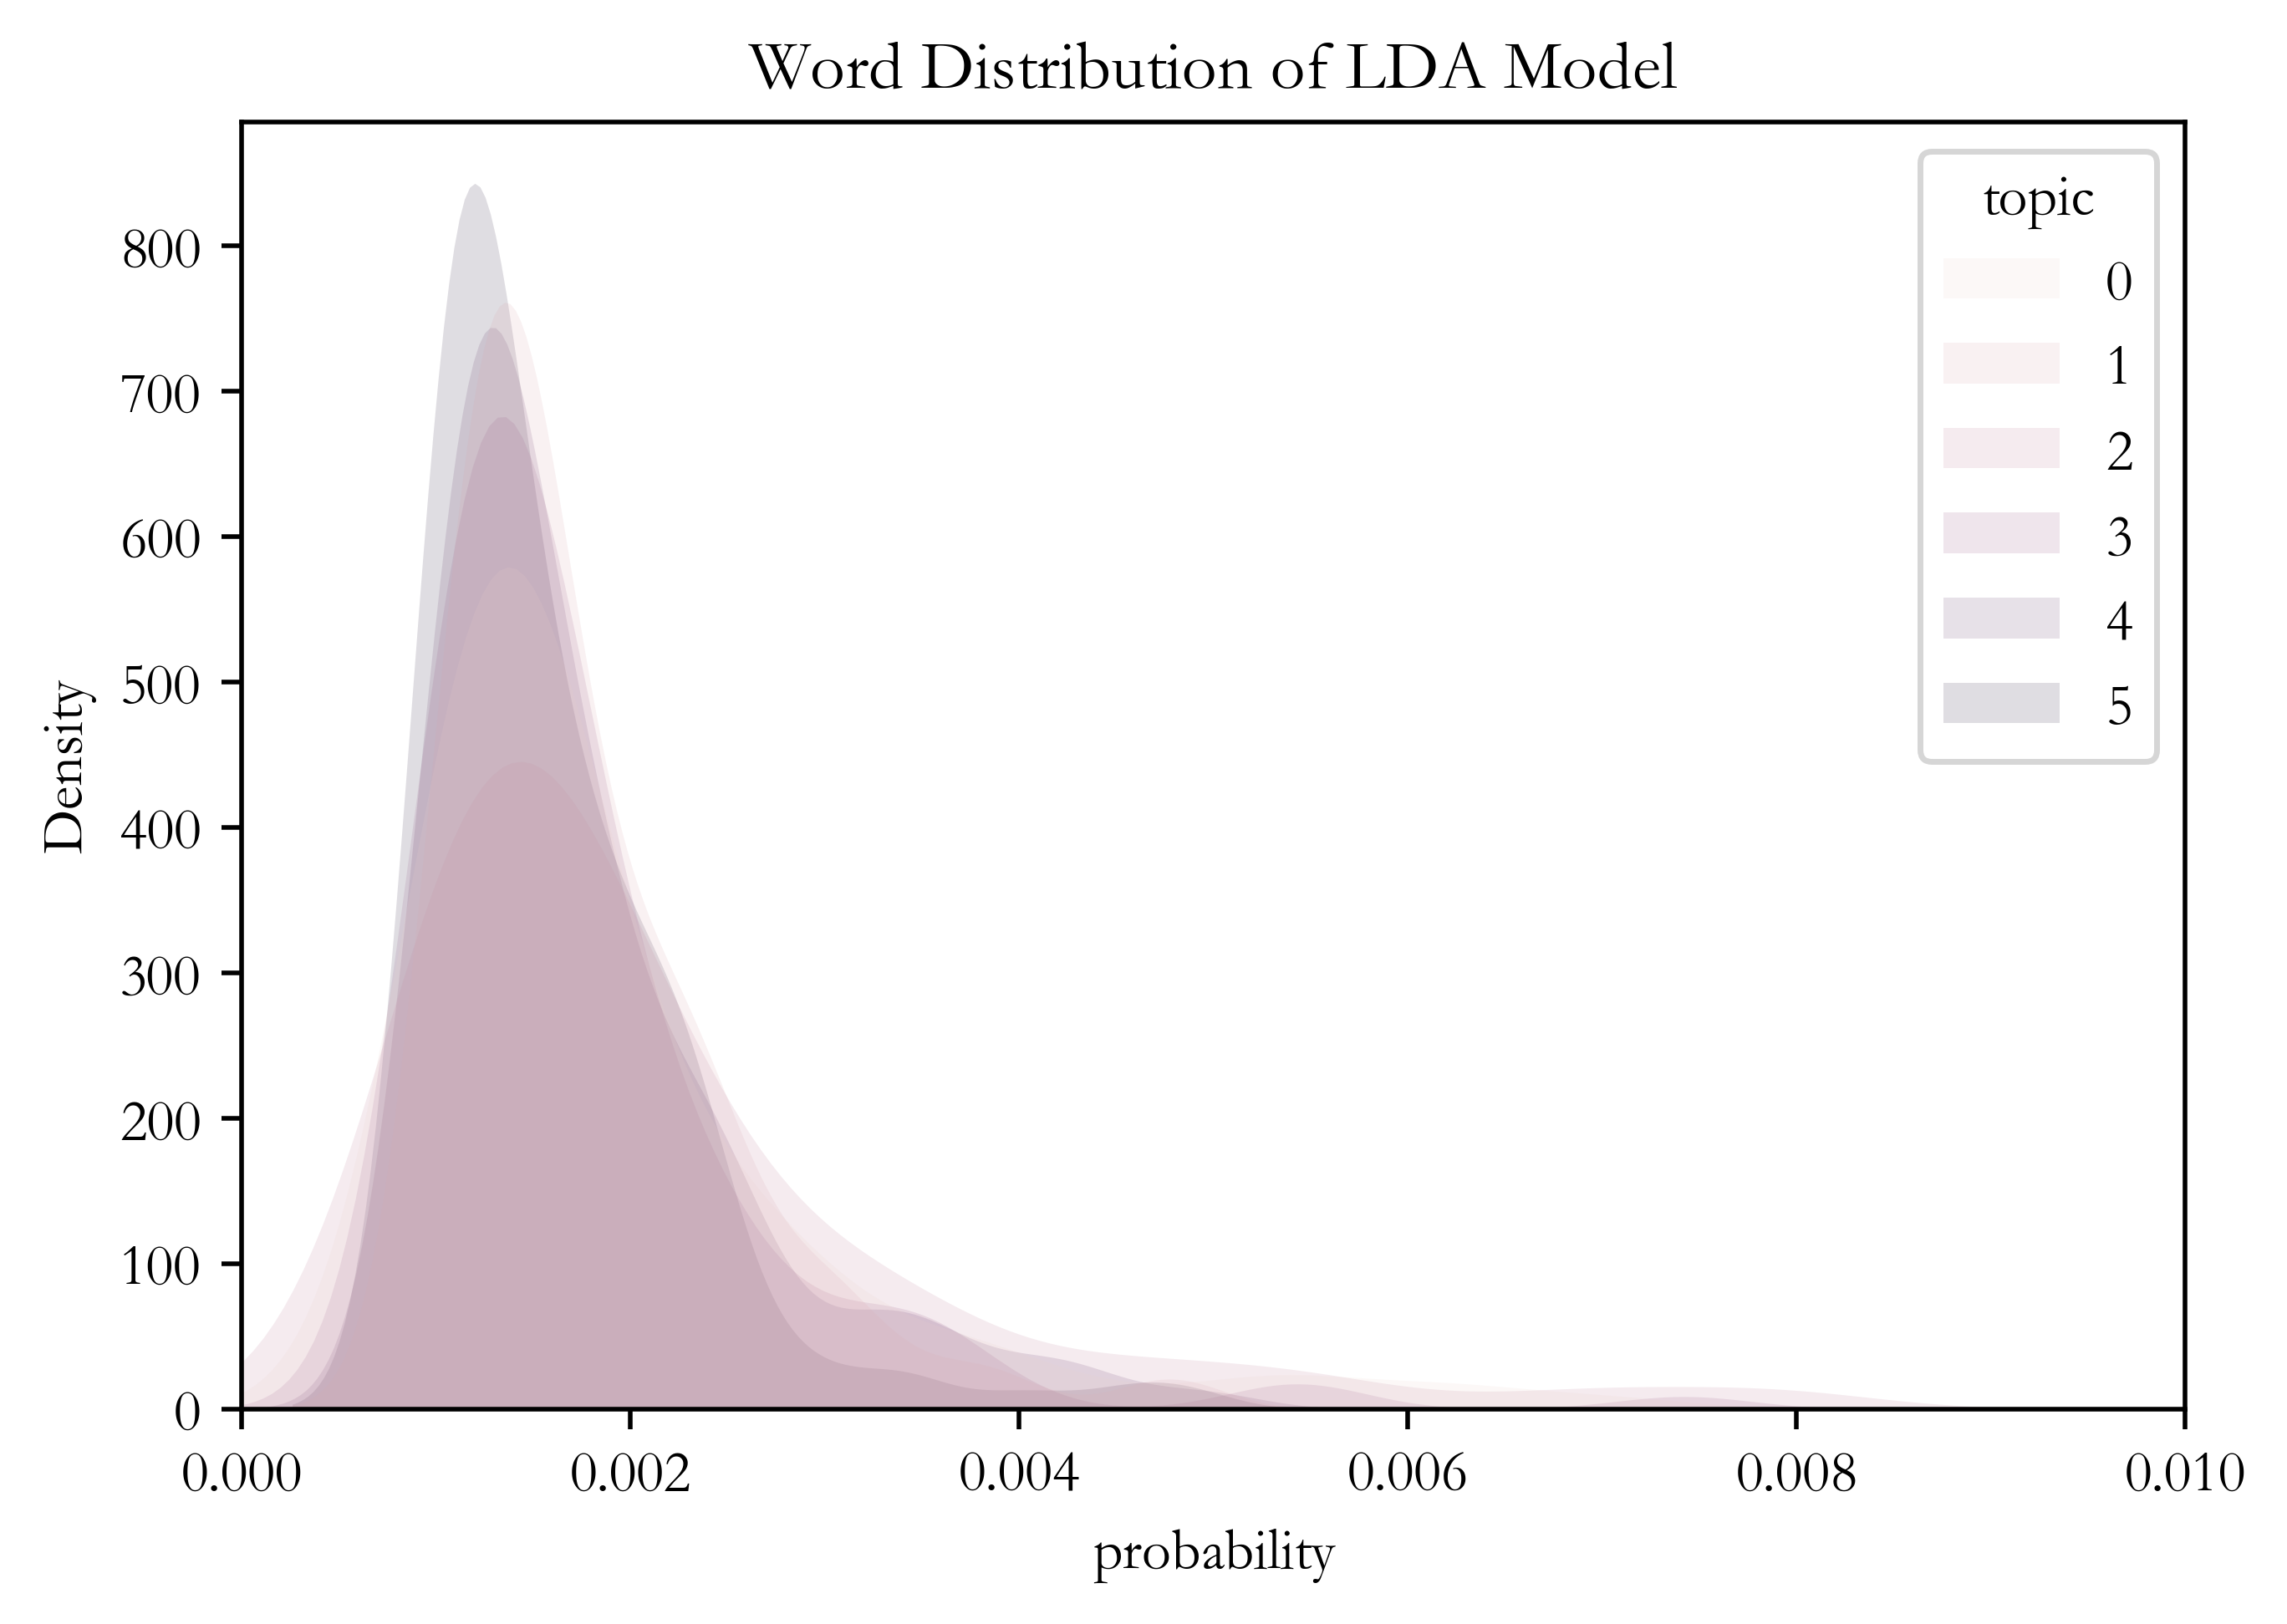

In [17]:
plt.figure(figsize = (6, 4), dpi=500)
word_dist_filter = word_dist[(word_dist['probability'] < 0.01) & (word_dist['probability'] > 0.001)]
sns.kdeplot(data=word_dist_filter,
            x='probability',
            hue='topic',
            fill=True,
            common_norm=False,
            # palette='PuRd_r',
            alpha=.15,
            linewidth=0)
plt.xlim(0, 0.01)
# plt.legend(range(20), ncol=3)
plt.title('Word Distribution of LDA Model')
plt.show()

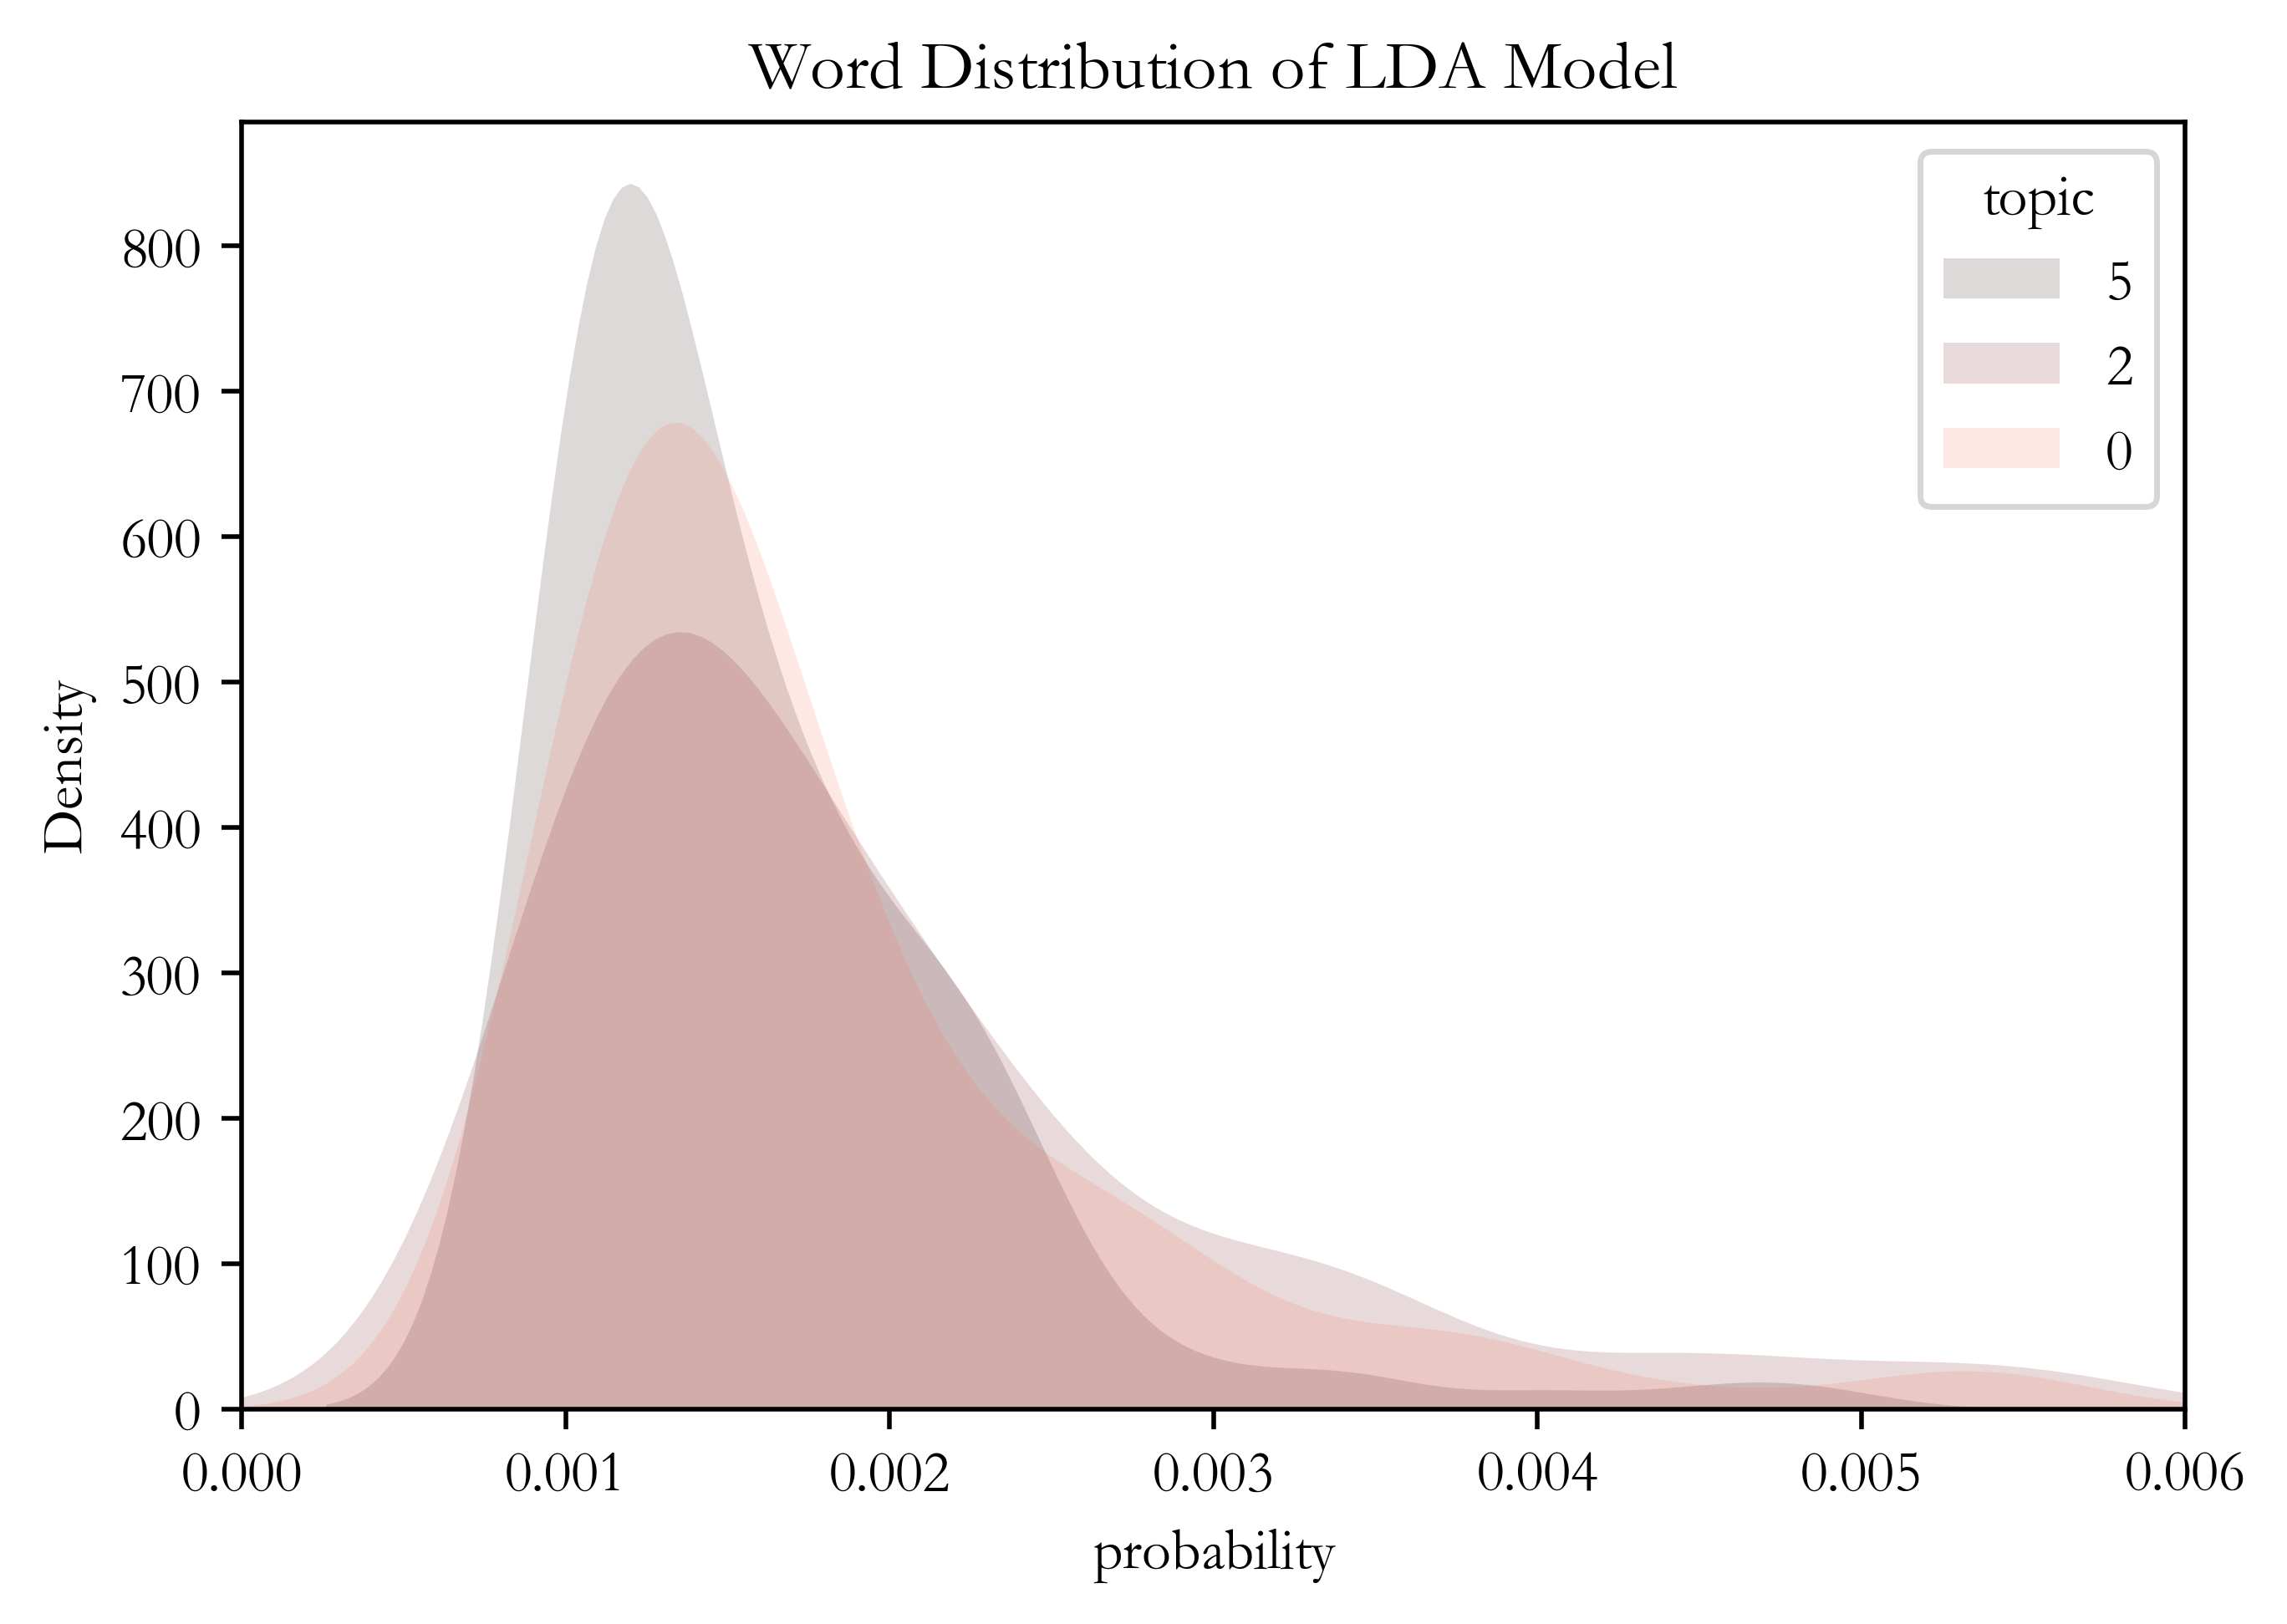

In [18]:
plt.figure(figsize = (6, 4), dpi=500)
word_dist_filter = word_dist[(word_dist['probability'] < 0.006) & (word_dist['probability'] > 0.001) & (word_dist['topic'] == 5)]
sns.kdeplot(data=word_dist_filter,
            x='probability',
            hue='topic',
            fill=True,
            common_norm=False,
            palette='pink',
            alpha=.15,
            linewidth=0,
            label=5)
word_dist_filter = word_dist[(word_dist['probability'] < 0.006) & (word_dist['probability'] > 0.001) & (word_dist['topic'] == 2)]
sns.kdeplot(data=word_dist_filter,
            x='probability',
            hue='topic',
            fill=True,
            common_norm=False,
            palette='Reds_r',
            alpha=.15,
            linewidth=0,
            label=2)
word_dist_filter = word_dist[(word_dist['probability'] < 0.006) & (word_dist['probability'] > 0.001) & (word_dist['topic'] == 0)]
sns.kdeplot(data=word_dist_filter,
            x='probability',
            hue='topic',
            fill=True,
            common_norm=False,
            palette='Reds',
            alpha=.15,
            linewidth=0,
            label=0)
plt.xlim(0, 0.006)
plt.legend(title='topic')
# plt.legend(range(20), ncol=3)
plt.title('Word Distribution of LDA Model')
plt.show()

查看所有谣言中主题的分布，发现0、1、2占比较多，3、5其次，4最少。

In [19]:
tmp = pd.DataFrame(df.groupby('all_topic')['content'].count()).reset_index()
tmp

,all_topic,content
0,0,89
1,1,83
2,2,75
3,3,50
4,4,29
5,5,40


In [20]:
pie = (
    Pie(init_opts=opts.InitOpts(width='960px', height='720px', theme=ThemeType.LIGHT))
    .add('', tmp.values.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title='文本主题分布'))
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}: {d}%'))
)

# 渲染图表
pie.render('LDA/LdaModel_pie_all.html')
pie.render_notebook()

## 2.2 词云图展示

我们已经用LDA模型计算出了每条谣言对应的topic，现在我们对每个topic画出词云图进行展示。

In [21]:
colorlist = ['Blues', 'BuPu', 'Greens', 'Greys', 'Oranges', 'PuBu', 'PuRd', 
             'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']

In [22]:
def draw_wordcloud(topicid, color='Blues'):
    freq = {dictionary[i]: lda_matrix[topicid][i] for i in range(len(dictionary))}
    stylecloud.gen_stylecloud(
        text=freq,
        font_path="wordcloud/STSong.ttf",
        size = 1000,
        icon_name='fas fa-cloud',
        palette='colorbrewer.sequential.' + color + '_7',
        background_color='white',
        max_words=200,
        stopwords=True,
        custom_stopwords=stopwords + ['发布', '谣言', '相关', '信息', '核实', '平台', '实', '官方', '有人', '发生', '实为'],
        collocations=False,
        # gradient='horizontal',
        output_name=f'wordcloud/wordcloudnew{topicid}.png'
    )
    return Image(filename = f'wordcloud/wordcloudnew{topicid}.png')

In [23]:
# for tid in range(num_topics):
#     draw_wordcloud(tid, colorlist[tid])

## 2.3 情感分析

对每条谣言计算出情感分数，存入变量emotion。

In [24]:
df['all_emotion'] = df['content'].apply(lambda x: SnowNLP(x).sentiments)

绘制情感分数直方图，发现靠近0和1的分布最为密集。这说明谣言都带有强烈的情感色彩，要么强烈正向，要么强烈负向。

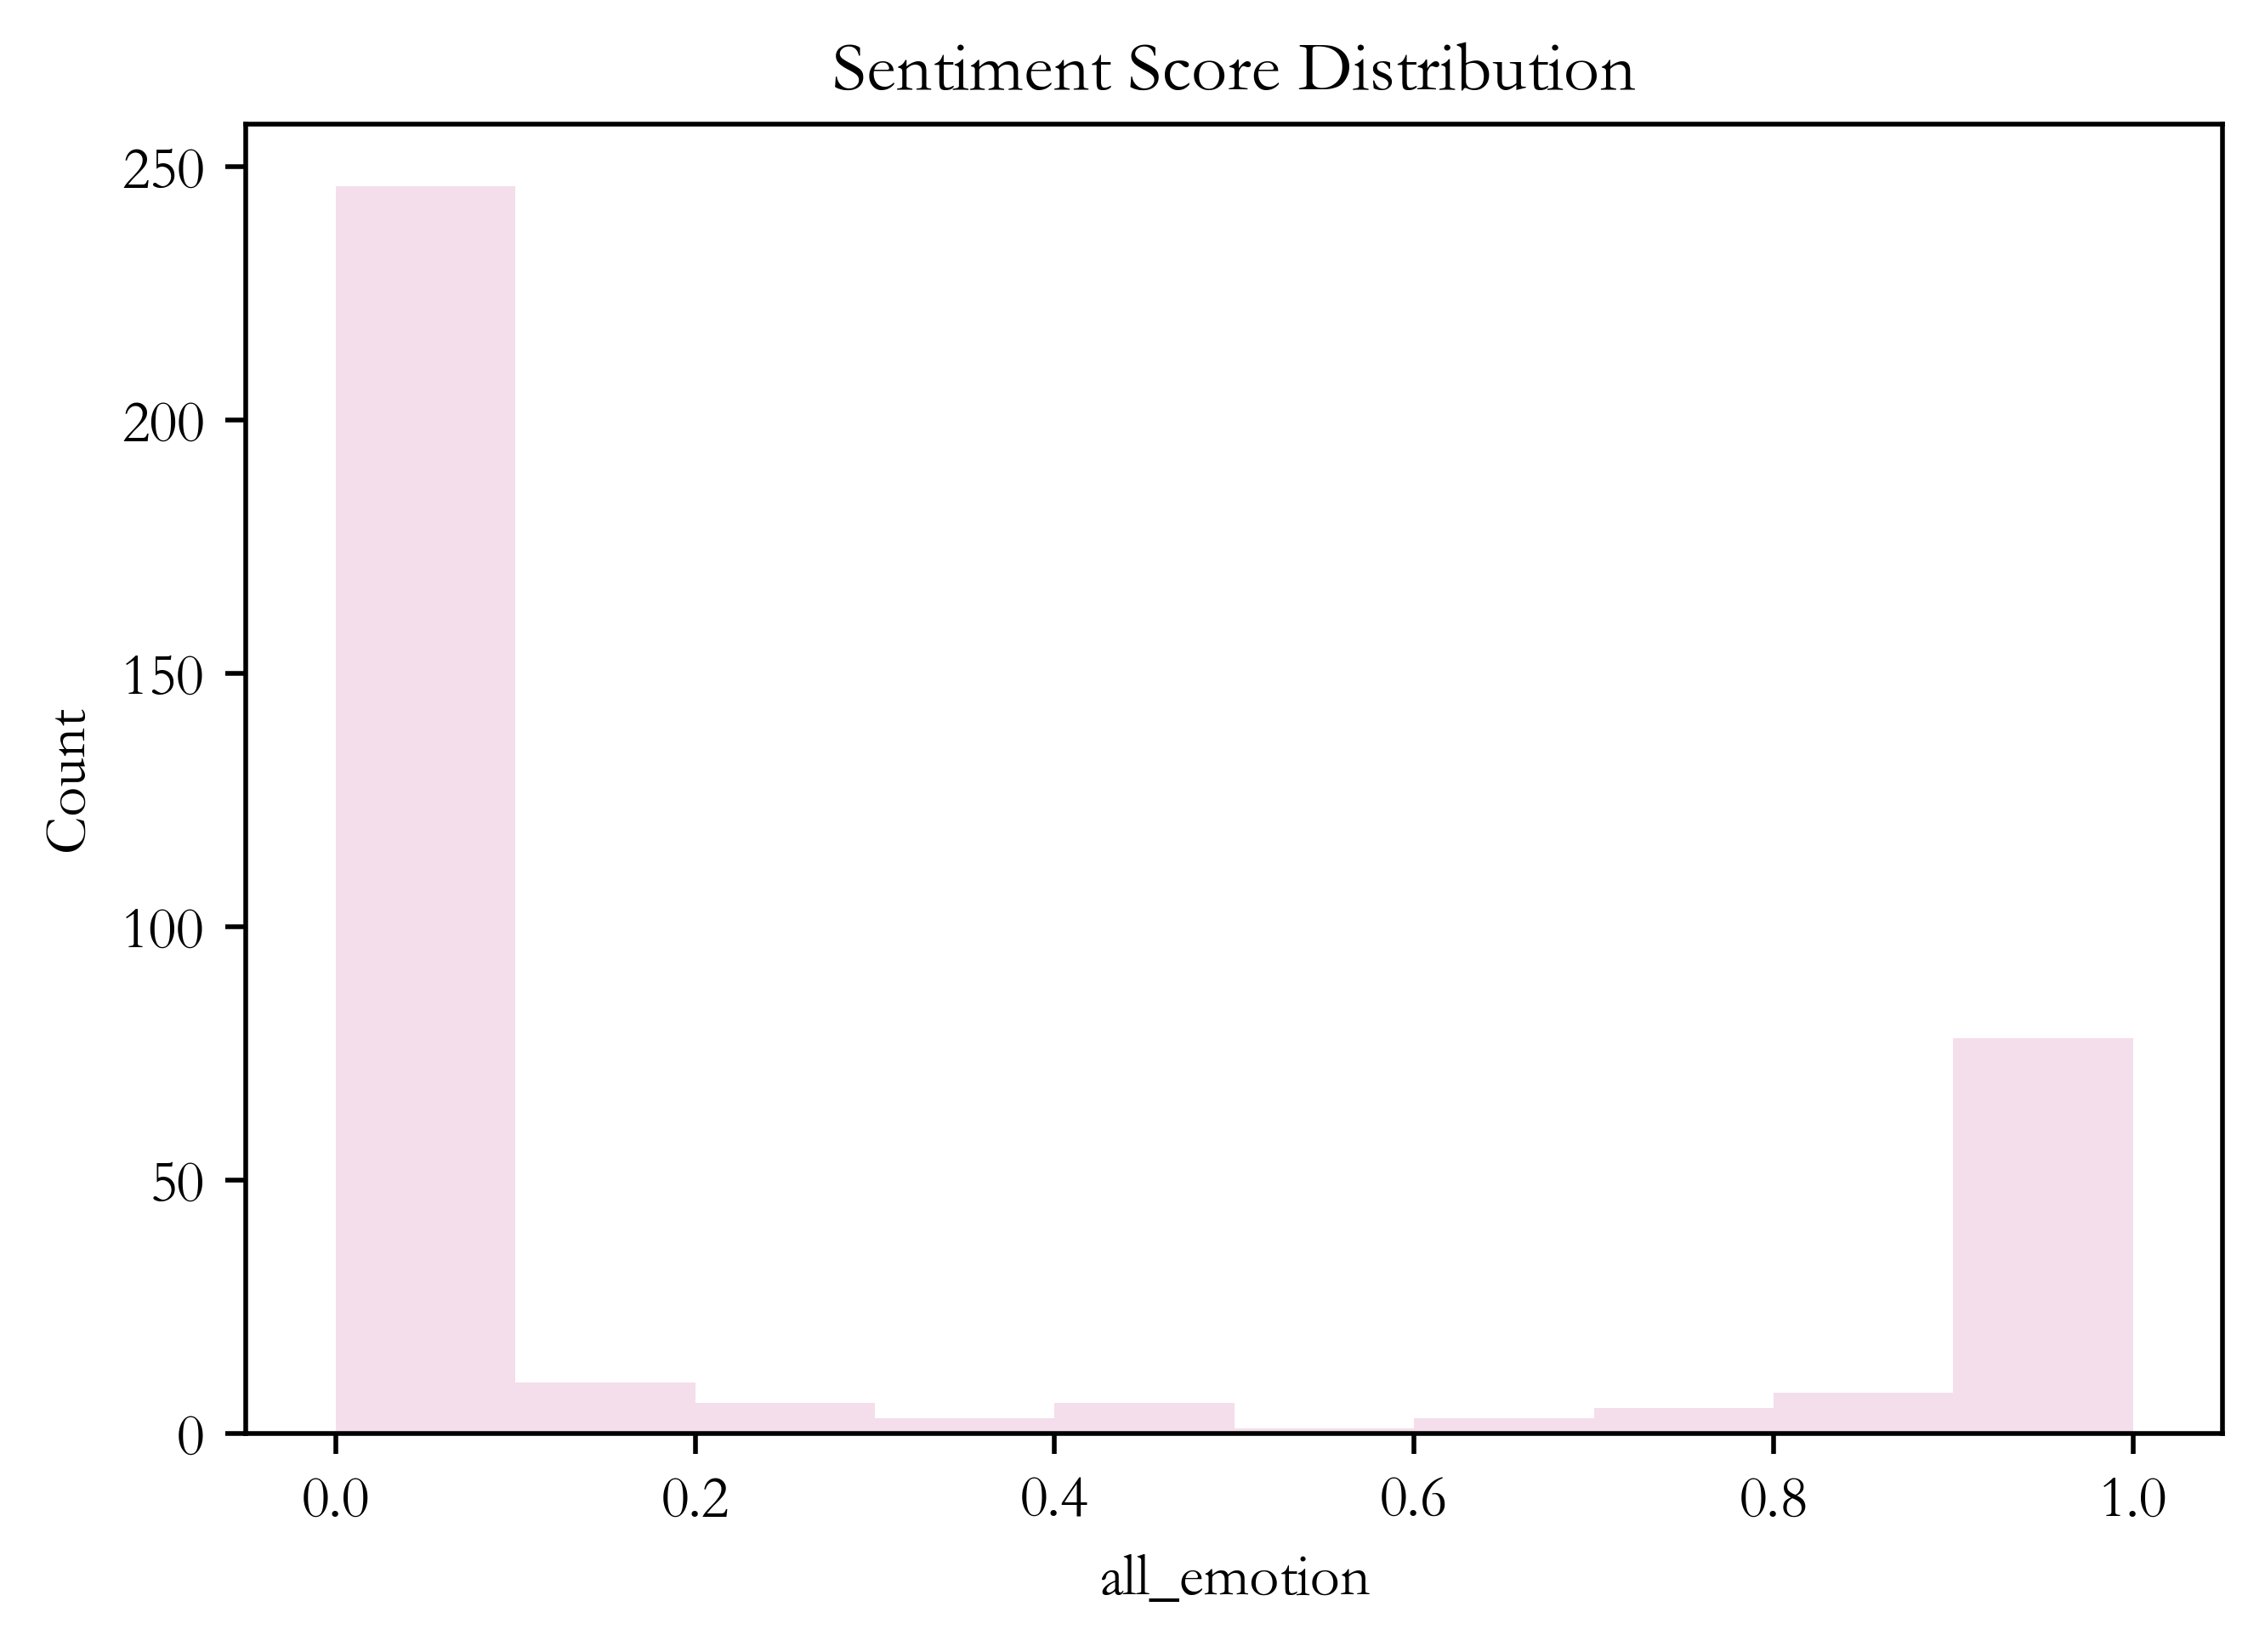

In [25]:
plt.figure(figsize = (6, 4), dpi=500)
sns.histplot(df['all_emotion'], linewidth=0, color='#F1D4E5', binwidth=0.1)
plt.title('Sentiment Score Distribution')
plt.show()

对LDA模型中的每个主题计算情感得分的均值，并画出相应的柱形图，发现所有topic的情感得分都为负。

In [26]:
tmp = pd.DataFrame(df.groupby('all_topic')['all_emotion'].mean() - 0.5).reset_index()
tmp.head()

,all_topic,all_emotion
0,0,-0.240280
1,1,-0.306180
2,2,-0.229934
3,3,-0.290573
4,4,-0.061967


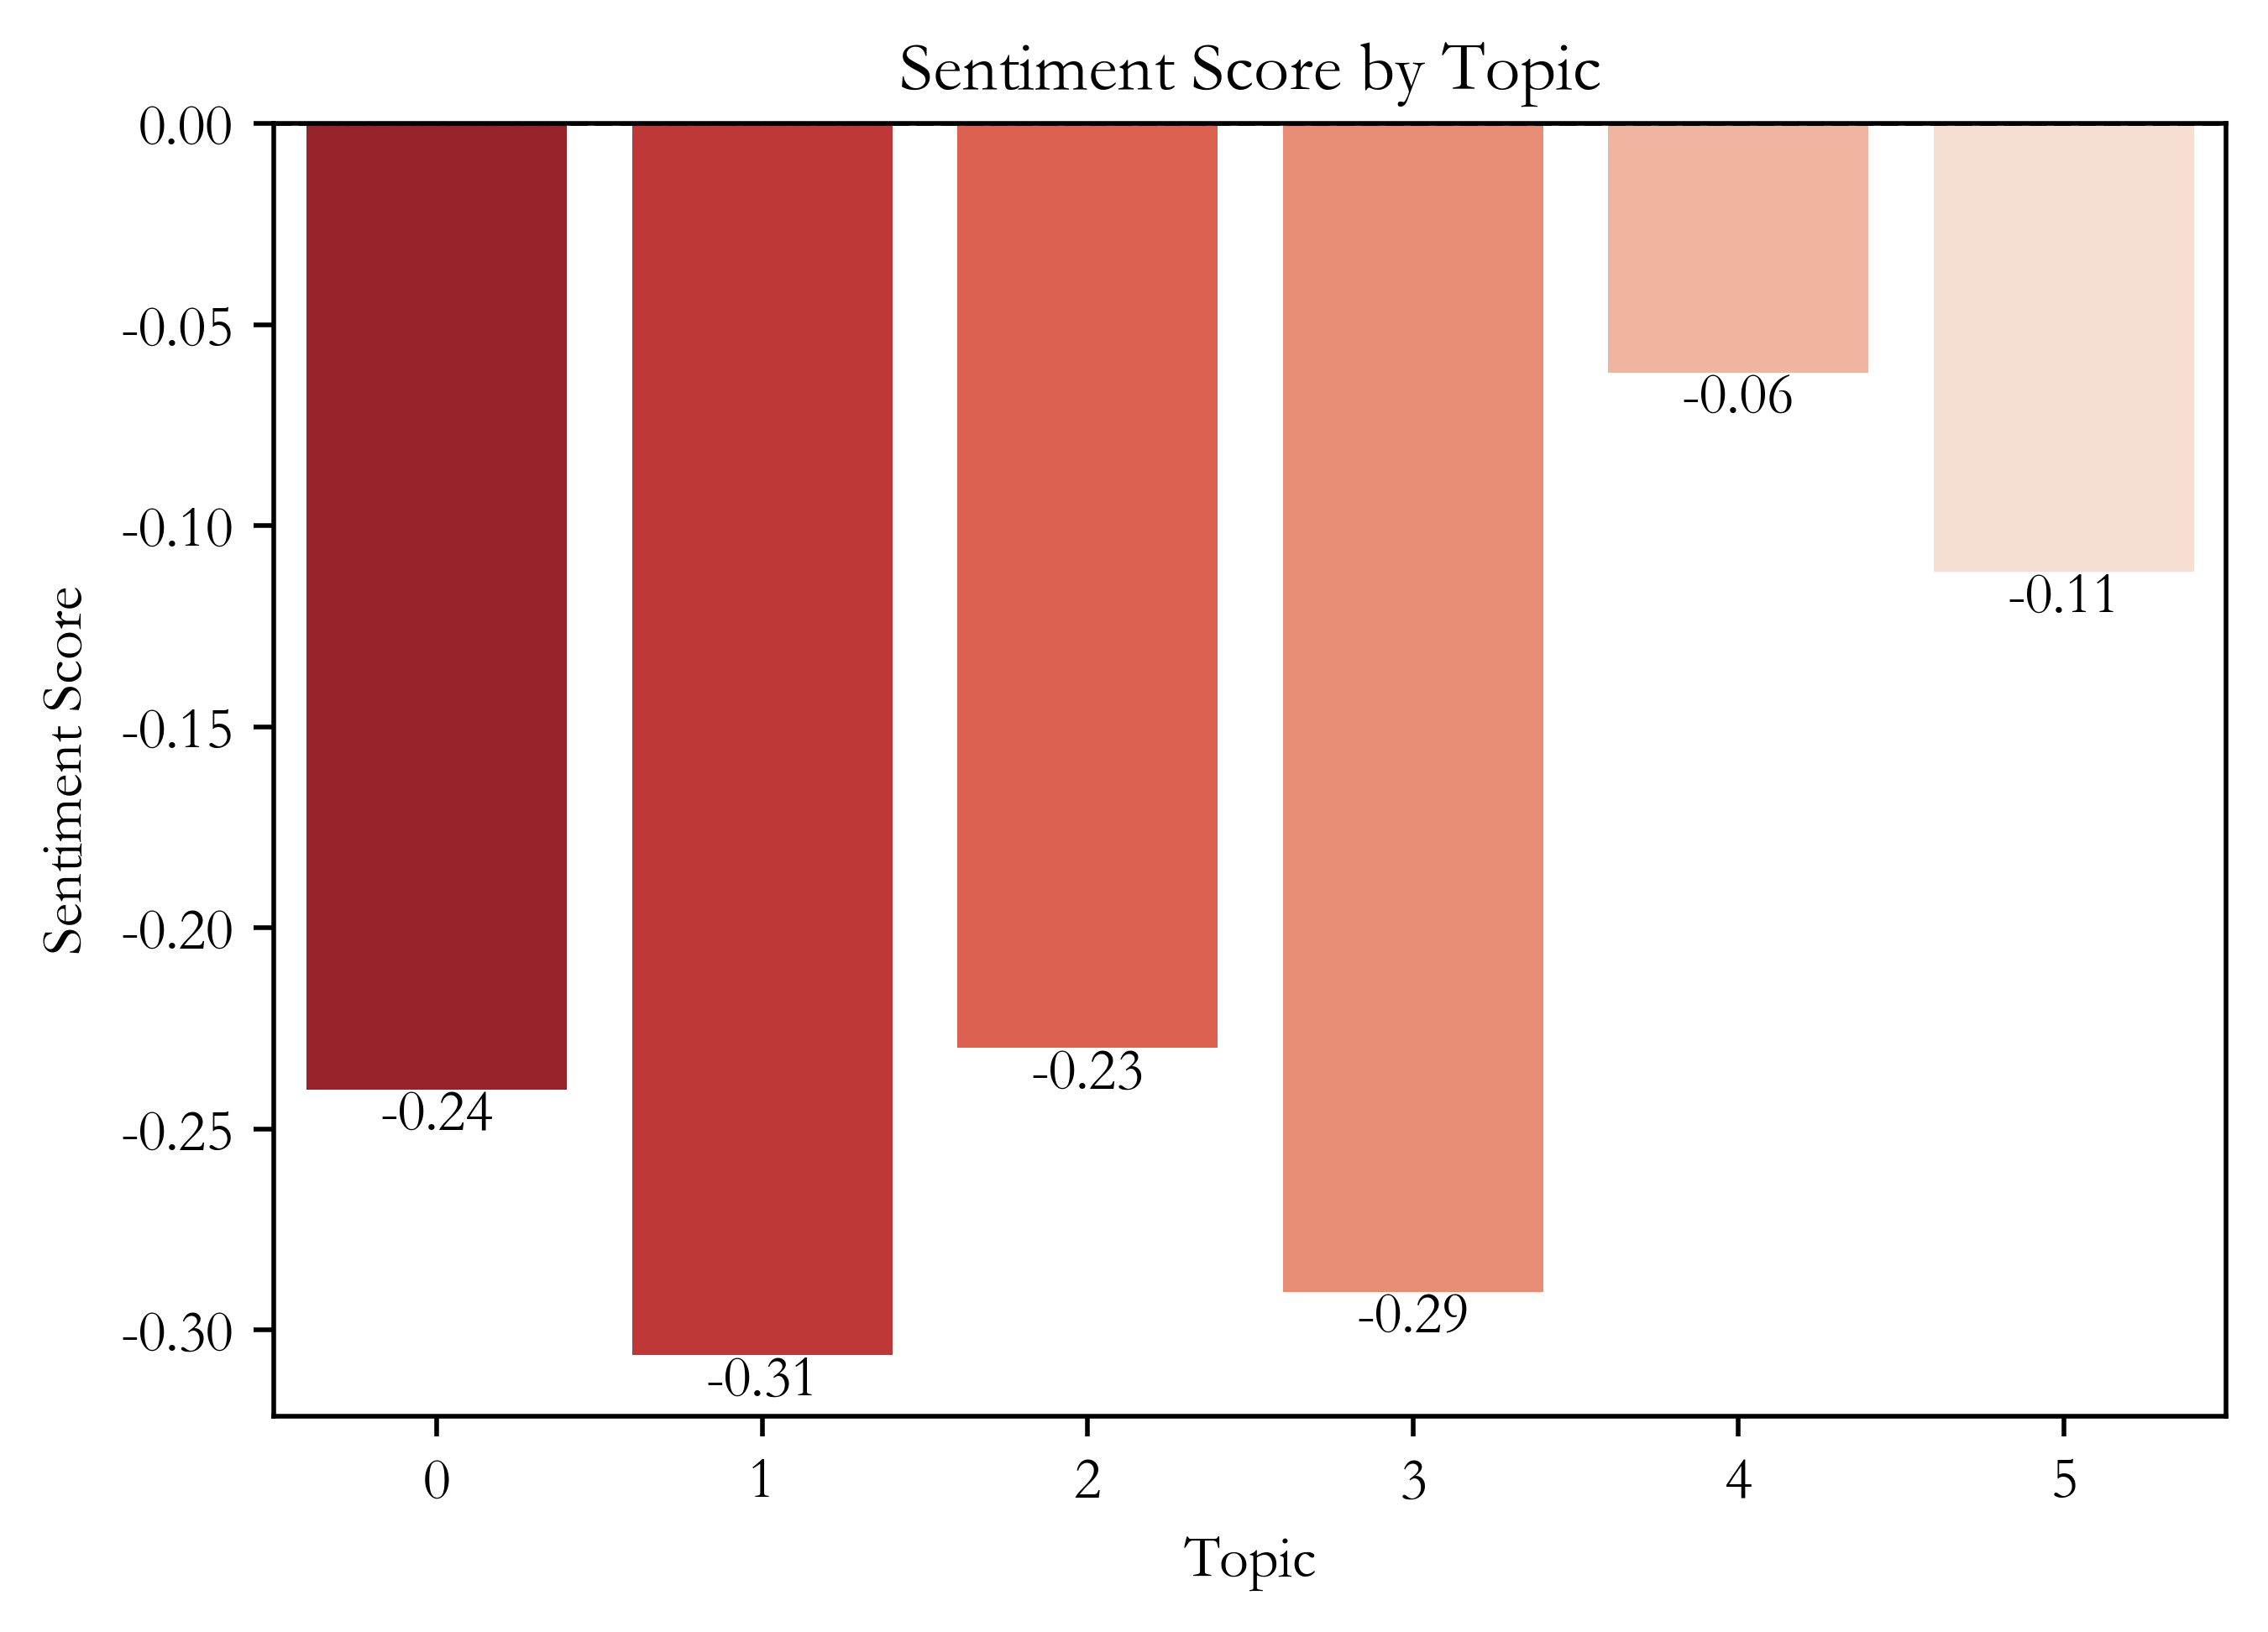

In [27]:
plt.figure(figsize = (6, 4), dpi=500)
plt.rcParams['axes.unicode_minus'] = False
#数据可视化
sns.barplot(y=tmp['all_emotion'], x=tmp['all_topic'], palette='Reds_r')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score by Topic')
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.8)
for a, b in zip(list(tmp['all_topic']), tmp['all_emotion']):
    if b < 0:
        va = 'top'
    else:
        va = 'bottom'
    plt.text(a, b, round(b, 2), ha = 'center', va = va, fontsize = 10)
plt.show()

比较主题的情感强烈程度。

In [28]:
df['abs_all_emotion'] = np.abs(df['all_emotion'] - 0.5)
tmp = pd.DataFrame(df.groupby('all_topic')['abs_all_emotion'].mean()).reset_index()
tmp.head()

,all_topic,abs_all_emotion
0,0,0.451434
1,1,0.483577
2,2,0.475172
3,3,0.489836
4,4,0.444246


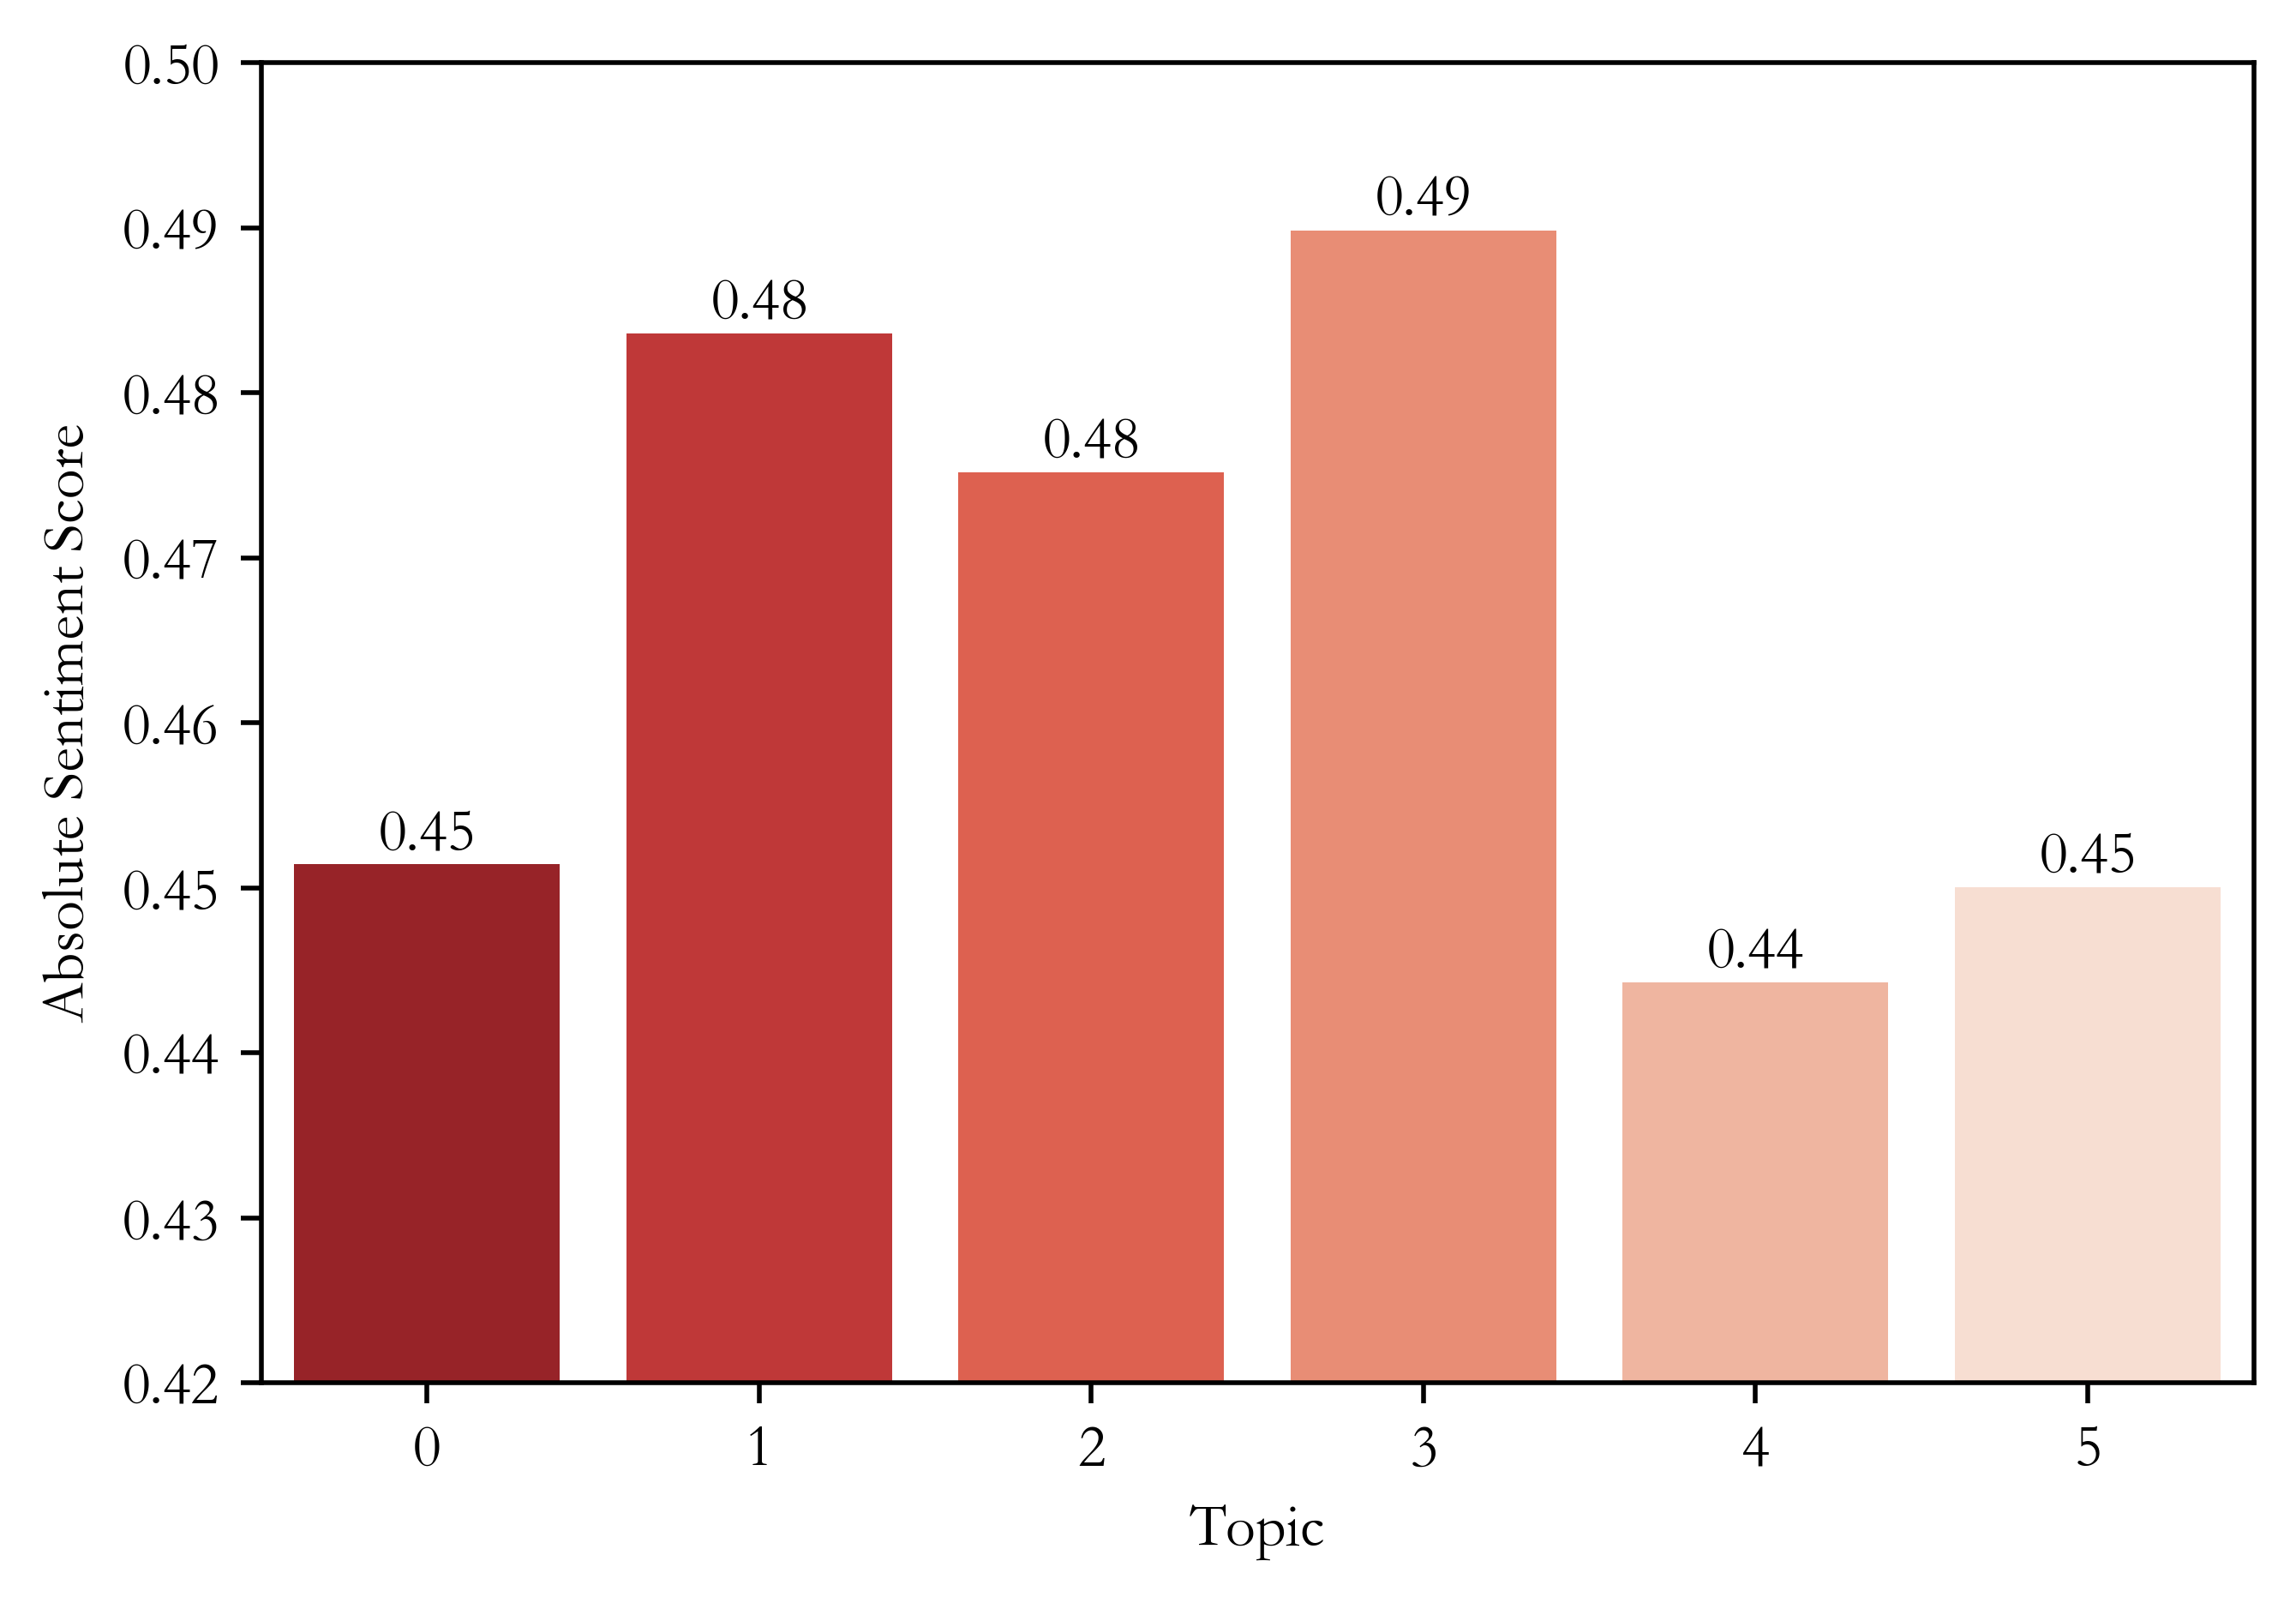

In [29]:
plt.figure(figsize = (6, 4), dpi=500)
plt.rcParams['axes.unicode_minus'] = False
#数据可视化
sns.barplot(y=tmp['abs_all_emotion'], x=tmp['all_topic'], palette='Reds_r')
plt.xlabel('Topic')
plt.ylabel('Absolute Sentiment Score')
# plt.title('Sentiment Score by Topic')
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.8)
for a, b in zip(list(tmp['all_topic']), tmp['abs_all_emotion']):
    if b < 0:
        va = 'top'
    else:
        va = 'bottom'
    plt.text(a, b, round(b, 2), ha = 'center', va = va, fontsize = 10)
plt.ylim(0.42, 0.5)
plt.show()

## 2.4 利用core列建立LDA模型

获取谣言核心信息的文本列表。

In [30]:
corpus = list(df.core)

读取停用词文件。

In [31]:
with open('LDA/stopwords_sub.txt', 'r') as f:
    stopwords = [line.strip() for line in f]
num_words = [str(i) for i in range(3000)]
stopwords = stopwords + num_words

获取除去停用词后的tokens列表。

In [32]:
tokenlist = [jieba.lcut(text, HMM=True) for text in corpus]
tokenlist = [[t for t in tokens if t not in stopwords] for tokens in tokenlist]

创建tokens字典。

In [33]:
dictionary = corpora.Dictionary(tokenlist)

创建bag of words列表。

In [34]:
bow = [dictionary.doc2bow(text) for text in tokenlist]

拟合LDA模型，主题定为12个，训练100轮。

In [35]:
num_topics = 12
# lda = LdaModel(corpus=bow, id2word=dictionary, num_topics=num_topics, passes=100)

保存LDA模型（这里为了可重复性，直接载入我已经训练好的模型）。

In [36]:
# lda.save('LDA/LdaModel12')
lda = LdaModel.load('LDA/LdaModel12')

用pyLDAvis可视化文本主题挖掘模型。

In [37]:
# d = pyLDAvis.gensim.prepare(lda, bow, dictionary)
# pyLDAvis.save_html(d, 'LDA/LdaModel_visulization_sub12.html')

查看所有topic中词的probability最高的前5个。

In [38]:
for topic in lda.print_topics(num_words = 5):
    termNumber = topic[0]
    print(topic[0], ':', sep='')
    listOfTerms = topic[1].split('+')
    for term in listOfTerms:
        listItems = term.split('*')
        print('   ', listItems[1].replace(' ', ''), ' (', listItems[0].replace(' ', ''), ')', sep='')

0:
   "确诊" (0.021)
   "病例" (0.014)
   "新冠" (0.010)
   "例新冠" (0.009)
   "码" (0.007)
1:
   "活动" (0.010)
   "家庭" (0.010)
   "秸秆" (0.010)
   "存款" (0.008)
   "考试" (0.008)
2:
   "双减" (0.009)
   "隔离" (0.007)
   "核酸" (0.006)
   "阳性" (0.006)
   "包" (0.006)
3:
   "调剂" (0.011)
   "养老" (0.008)
   "健康" (0.005)
   "路" (0.005)
   "系统" (0.005)
4:
   "确诊" (0.011)
   "修复" (0.008)
   "疫情" (0.008)
   "快递" (0.007)
   "影响" (0.005)
5:
   "疫情" (0.015)
   "阳性" (0.010)
   "防控" (0.010)
   "新冠" (0.009)
   "通知" (0.007)
6:
   "阳性" (0.009)
   "吃" (0.009)
   "发生" (0.007)
   "感染者" (0.007)
   "居民" (0.005)
7:
   "阳性" (0.026)
   "核酸" (0.020)
   "检测" (0.018)
   "小区" (0.017)
   "物资" (0.009)
8:
   "出血热" (0.013)
   "上海" (0.010)
   "致癌" (0.010)
   "吃" (0.006)
   "投资" (0.006)
9:
   "检测" (0.021)
   "确诊" (0.018)
   "医院" (0.016)
   "方舱" (0.013)
   "核酸" (0.012)
10:
   "检测" (0.010)
   "营业" (0.009)
   "新冠" (0.008)
   "确诊" (0.008)
   "阳性" (0.008)
11:
   "病例" (0.011)
   "青岛" (0.009)
   "东莞" (0.009)
   "确诊" (0.009)
   "北京" (0.007)


获取每条消息对应的topic和概率。

In [39]:
document_topics = lda.get_document_topics(bow)
topic_list = []
prob_list = []
for topics in document_topics:
    if len(topics) > 1:
        max_prob = 0
        for i, topic in enumerate(topics):
            if topic[1] > max_prob:
                best_topic = i
                max_prob = topic[1]
    else:
        best_topic = topics[0][0]
        max_prob = topics[0][1]
    topic_list.append(best_topic)
    prob_list.append(max_prob)
    print(f'Topic: {best_topic}, Probability: {max_prob:.2f}')

Topic: 6, Probability: 0.87
Topic: 11, Probability: 0.85
Topic: 11, Probability: 0.95
Topic: 9, Probability: 0.92
Topic: 3, Probability: 0.87
Topic: 4, Probability: 0.90
Topic: 5, Probability: 0.95
Topic: 11, Probability: 0.91
Topic: 0, Probability: 0.87
Topic: 3, Probability: 0.89
Topic: 6, Probability: 0.85
Topic: 8, Probability: 0.95
Topic: 5, Probability: 0.97
Topic: 10, Probability: 0.96
Topic: 7, Probability: 0.92
Topic: 0, Probability: 0.91
Topic: 9, Probability: 0.50
Topic: 5, Probability: 0.96
Topic: 10, Probability: 0.95
Topic: 10, Probability: 0.91
Topic: 2, Probability: 0.82
Topic: 1, Probability: 0.93
Topic: 3, Probability: 0.92
Topic: 2, Probability: 0.91
Topic: 1, Probability: 0.53
Topic: 9, Probability: 0.99
Topic: 2, Probability: 0.93
Topic: 10, Probability: 0.92
Topic: 8, Probability: 0.97
Topic: 10, Probability: 0.93
Topic: 10, Probability: 0.99
Topic: 1, Probability: 0.98
Topic: 5, Probability: 0.87
Topic: 3, Probability: 0.95
Topic: 11, Probability: 0.93
Topic: 8, 

Topic: 3, Probability: 0.97
Topic: 0, Probability: 0.85
Topic: 10, Probability: 0.96
Topic: 1, Probability: 0.93
Topic: 6, Probability: 0.93
Topic: 10, Probability: 0.92
Topic: 7, Probability: 0.85
Topic: 3, Probability: 0.94
Topic: 0, Probability: 0.96
Topic: 1, Probability: 0.85
Topic: 4, Probability: 0.95
Topic: 4, Probability: 0.95
Topic: 4, Probability: 0.94
Topic: 2, Probability: 0.95
Topic: 2, Probability: 0.92
Topic: 4, Probability: 0.96
Topic: 3, Probability: 0.96
Topic: 3, Probability: 0.93
Topic: 9, Probability: 0.94
Topic: 10, Probability: 0.93
Topic: 4, Probability: 0.94
Topic: 3, Probability: 0.92
Topic: 0, Probability: 0.82
Topic: 5, Probability: 0.95
Topic: 2, Probability: 0.77
Topic: 3, Probability: 0.91
Topic: 1, Probability: 0.98
Topic: 10, Probability: 0.93
Topic: 9, Probability: 0.87
Topic: 3, Probability: 0.89
Topic: 7, Probability: 0.77
Topic: 11, Probability: 0.87
Topic: 4, Probability: 0.95
Topic: 5, Probability: 0.85
Topic: 4, Probability: 0.89
Topic: 4, Proba

将topic和相应概率保存到数据中。

In [40]:
df['sub_topic'] = topic_list
df['sub_prob'] = prob_list

In [41]:
lda.show_topic(1) # 根据主题找对应频率最高的词（中文对应）
lda.get_topic_terms(0, topn=10) # 根据主题找对应频率最高的词（词的id）

[(80, 0.02058294),
 (67, 0.013843517),
 (73, 0.010352249),
 (403, 0.008890757),
 (1168, 0.007429244),
 (169, 0.007429202),
 (150, 0.005967733),
 (248, 0.005967733),
 (487, 0.0059677274),
 (340, 0.005967726)]

查看模型各个主题之间的相似度。

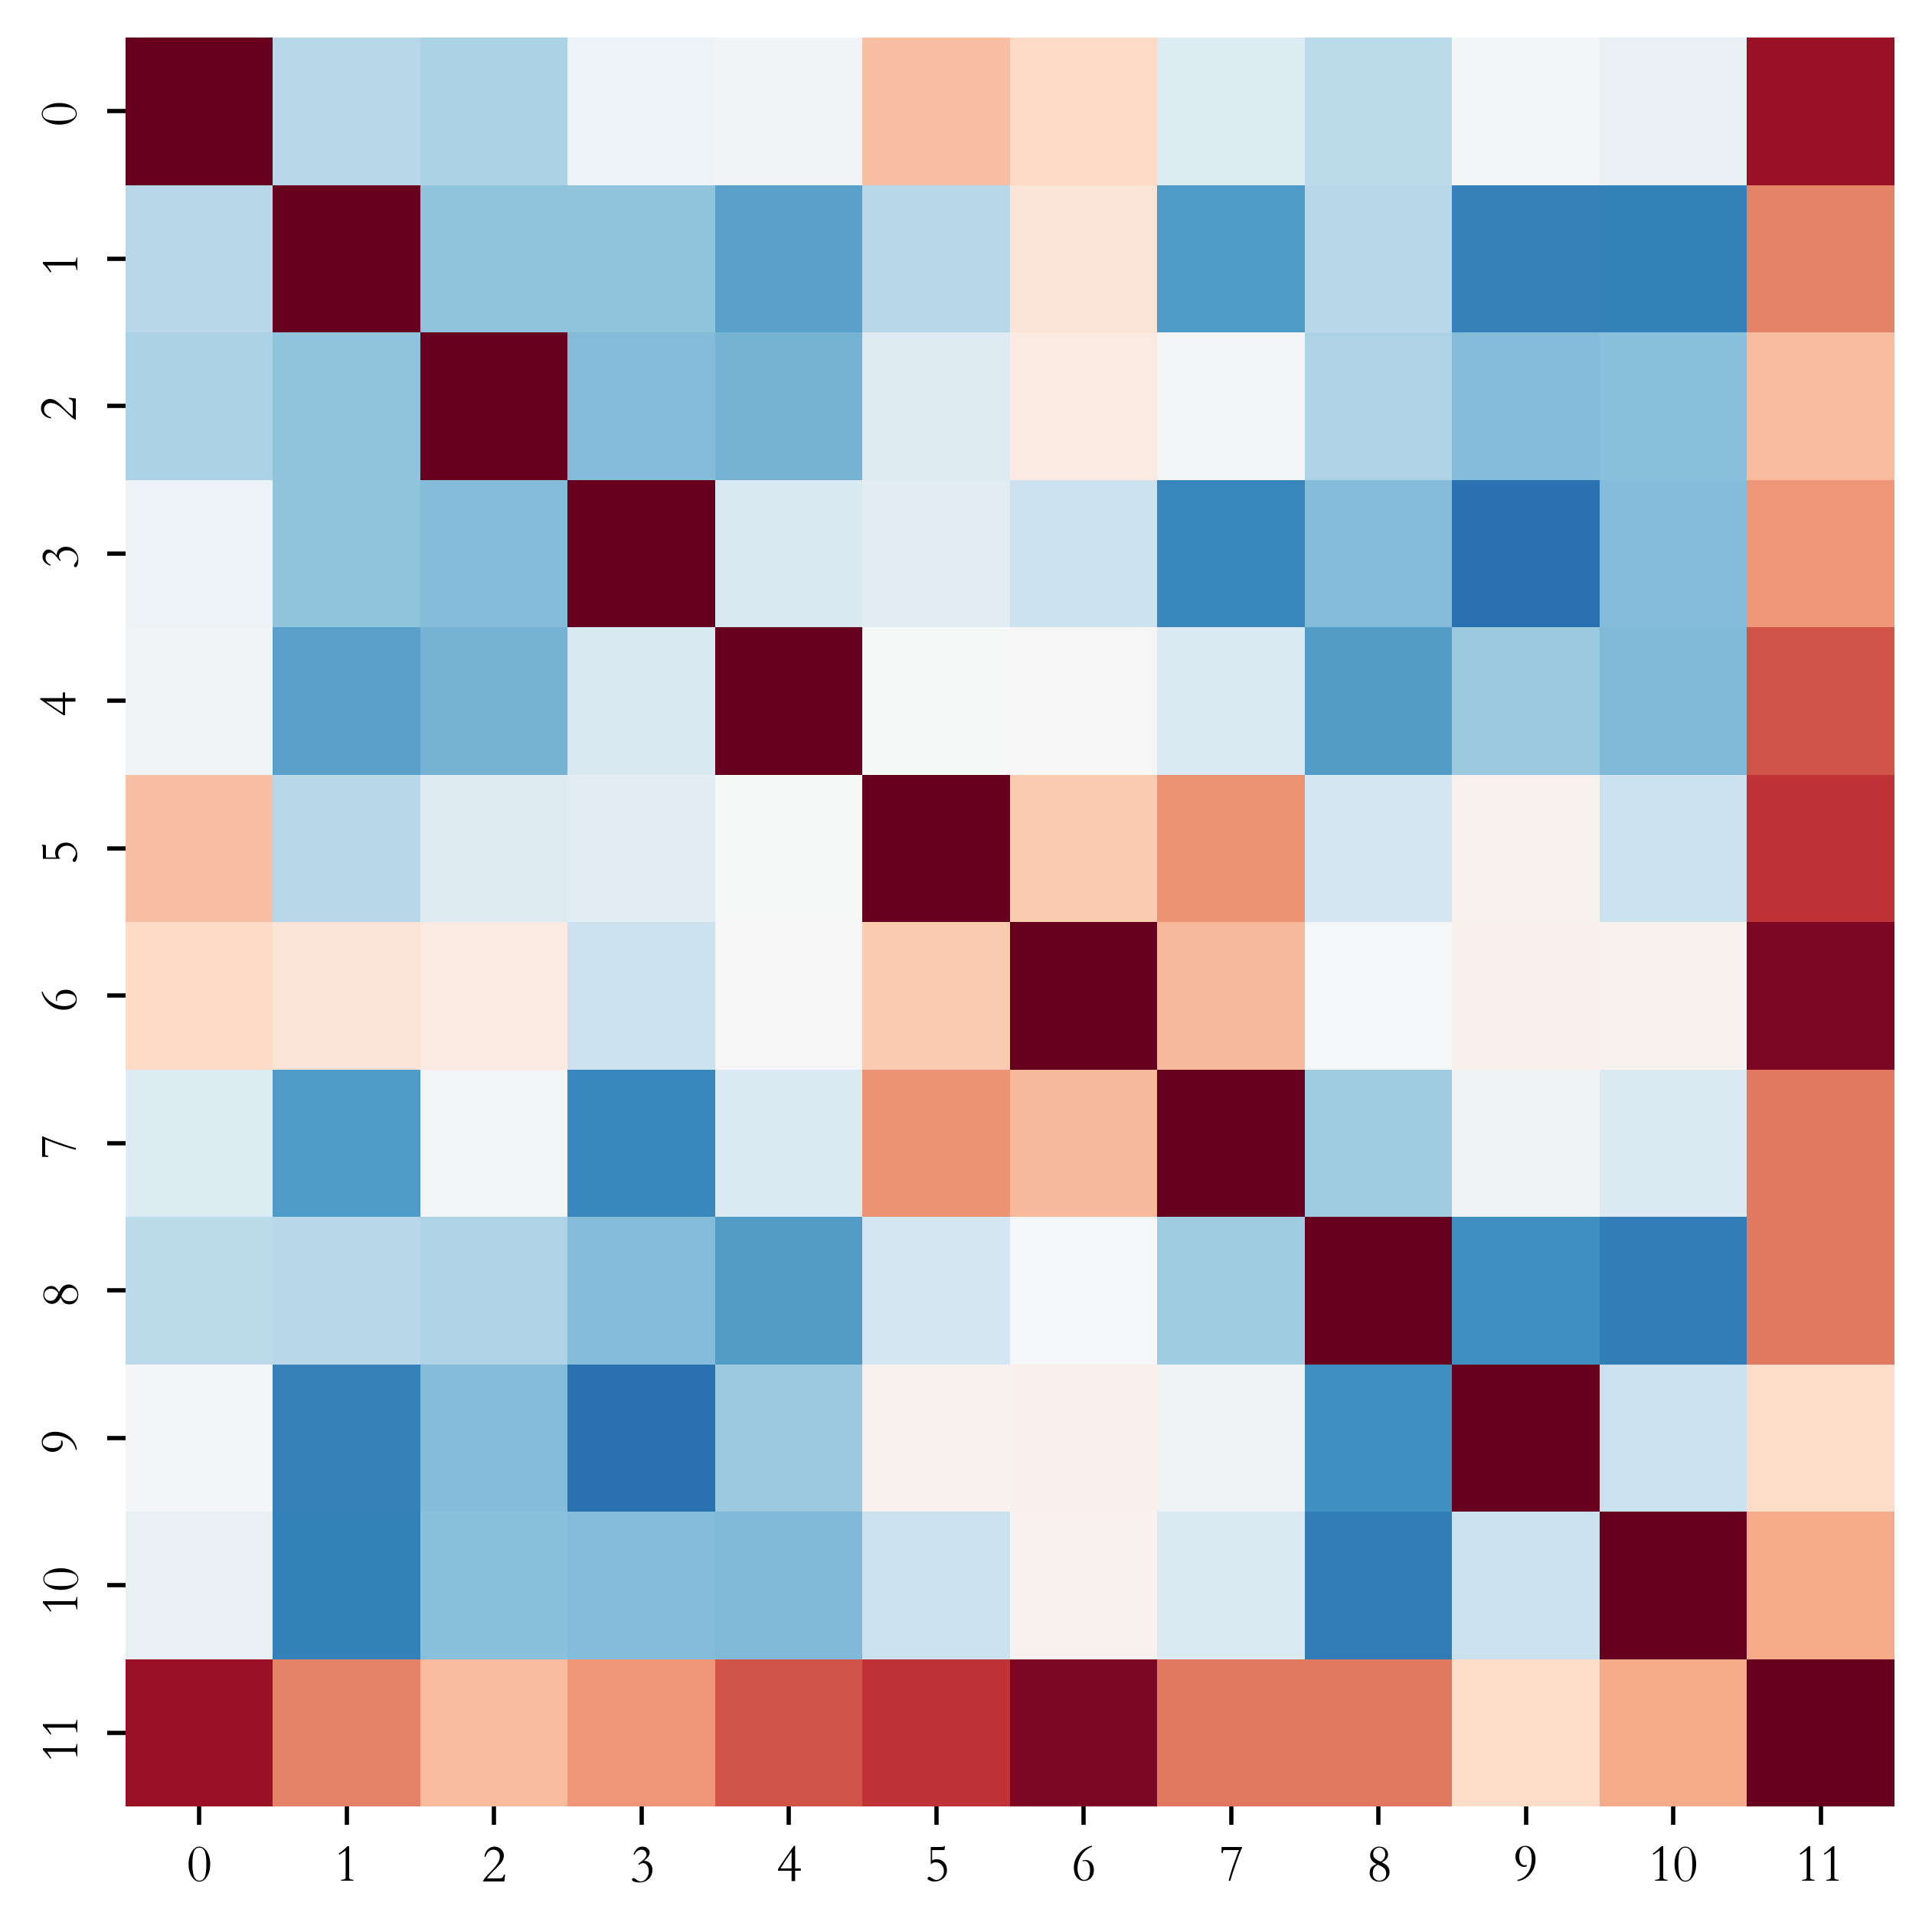

In [42]:
mdiff, annotation = lda.diff(lda, distance='hellinger', num_words=50)
plt.figure(figsize = (6, 6), dpi=500)
sns.heatmap(1 / (1 + mdiff), cbar=False, annot=False, square=True, fmt='.2f',
            # annot_kws={'size': 10}
            vmin=0.495, vmax=0.535, cmap='RdBu_r')
plt.show()

查看每个主题的word distribution。

In [43]:
lda_matrix = lda.get_topics()
word_dist = pd.DataFrame(np.zeros((num_topics * lda_matrix.shape[1], 3)))
word_dist.columns = ['word', 'topic', 'probability']
word_dist['word'] = list(range(lda_matrix.shape[1])) * num_topics
word_dist['topic'] = np.concatenate([[i] * lda_matrix.shape[1] for i in range(num_topics)])
word_dist['probability'] = np.concatenate(lda_matrix)
word_dist.head()

,word,topic,probability
0,0,0,0.000122
1,1,0,0.003045
2,2,0,0.000122
3,3,0,0.000122
4,4,0,0.000122


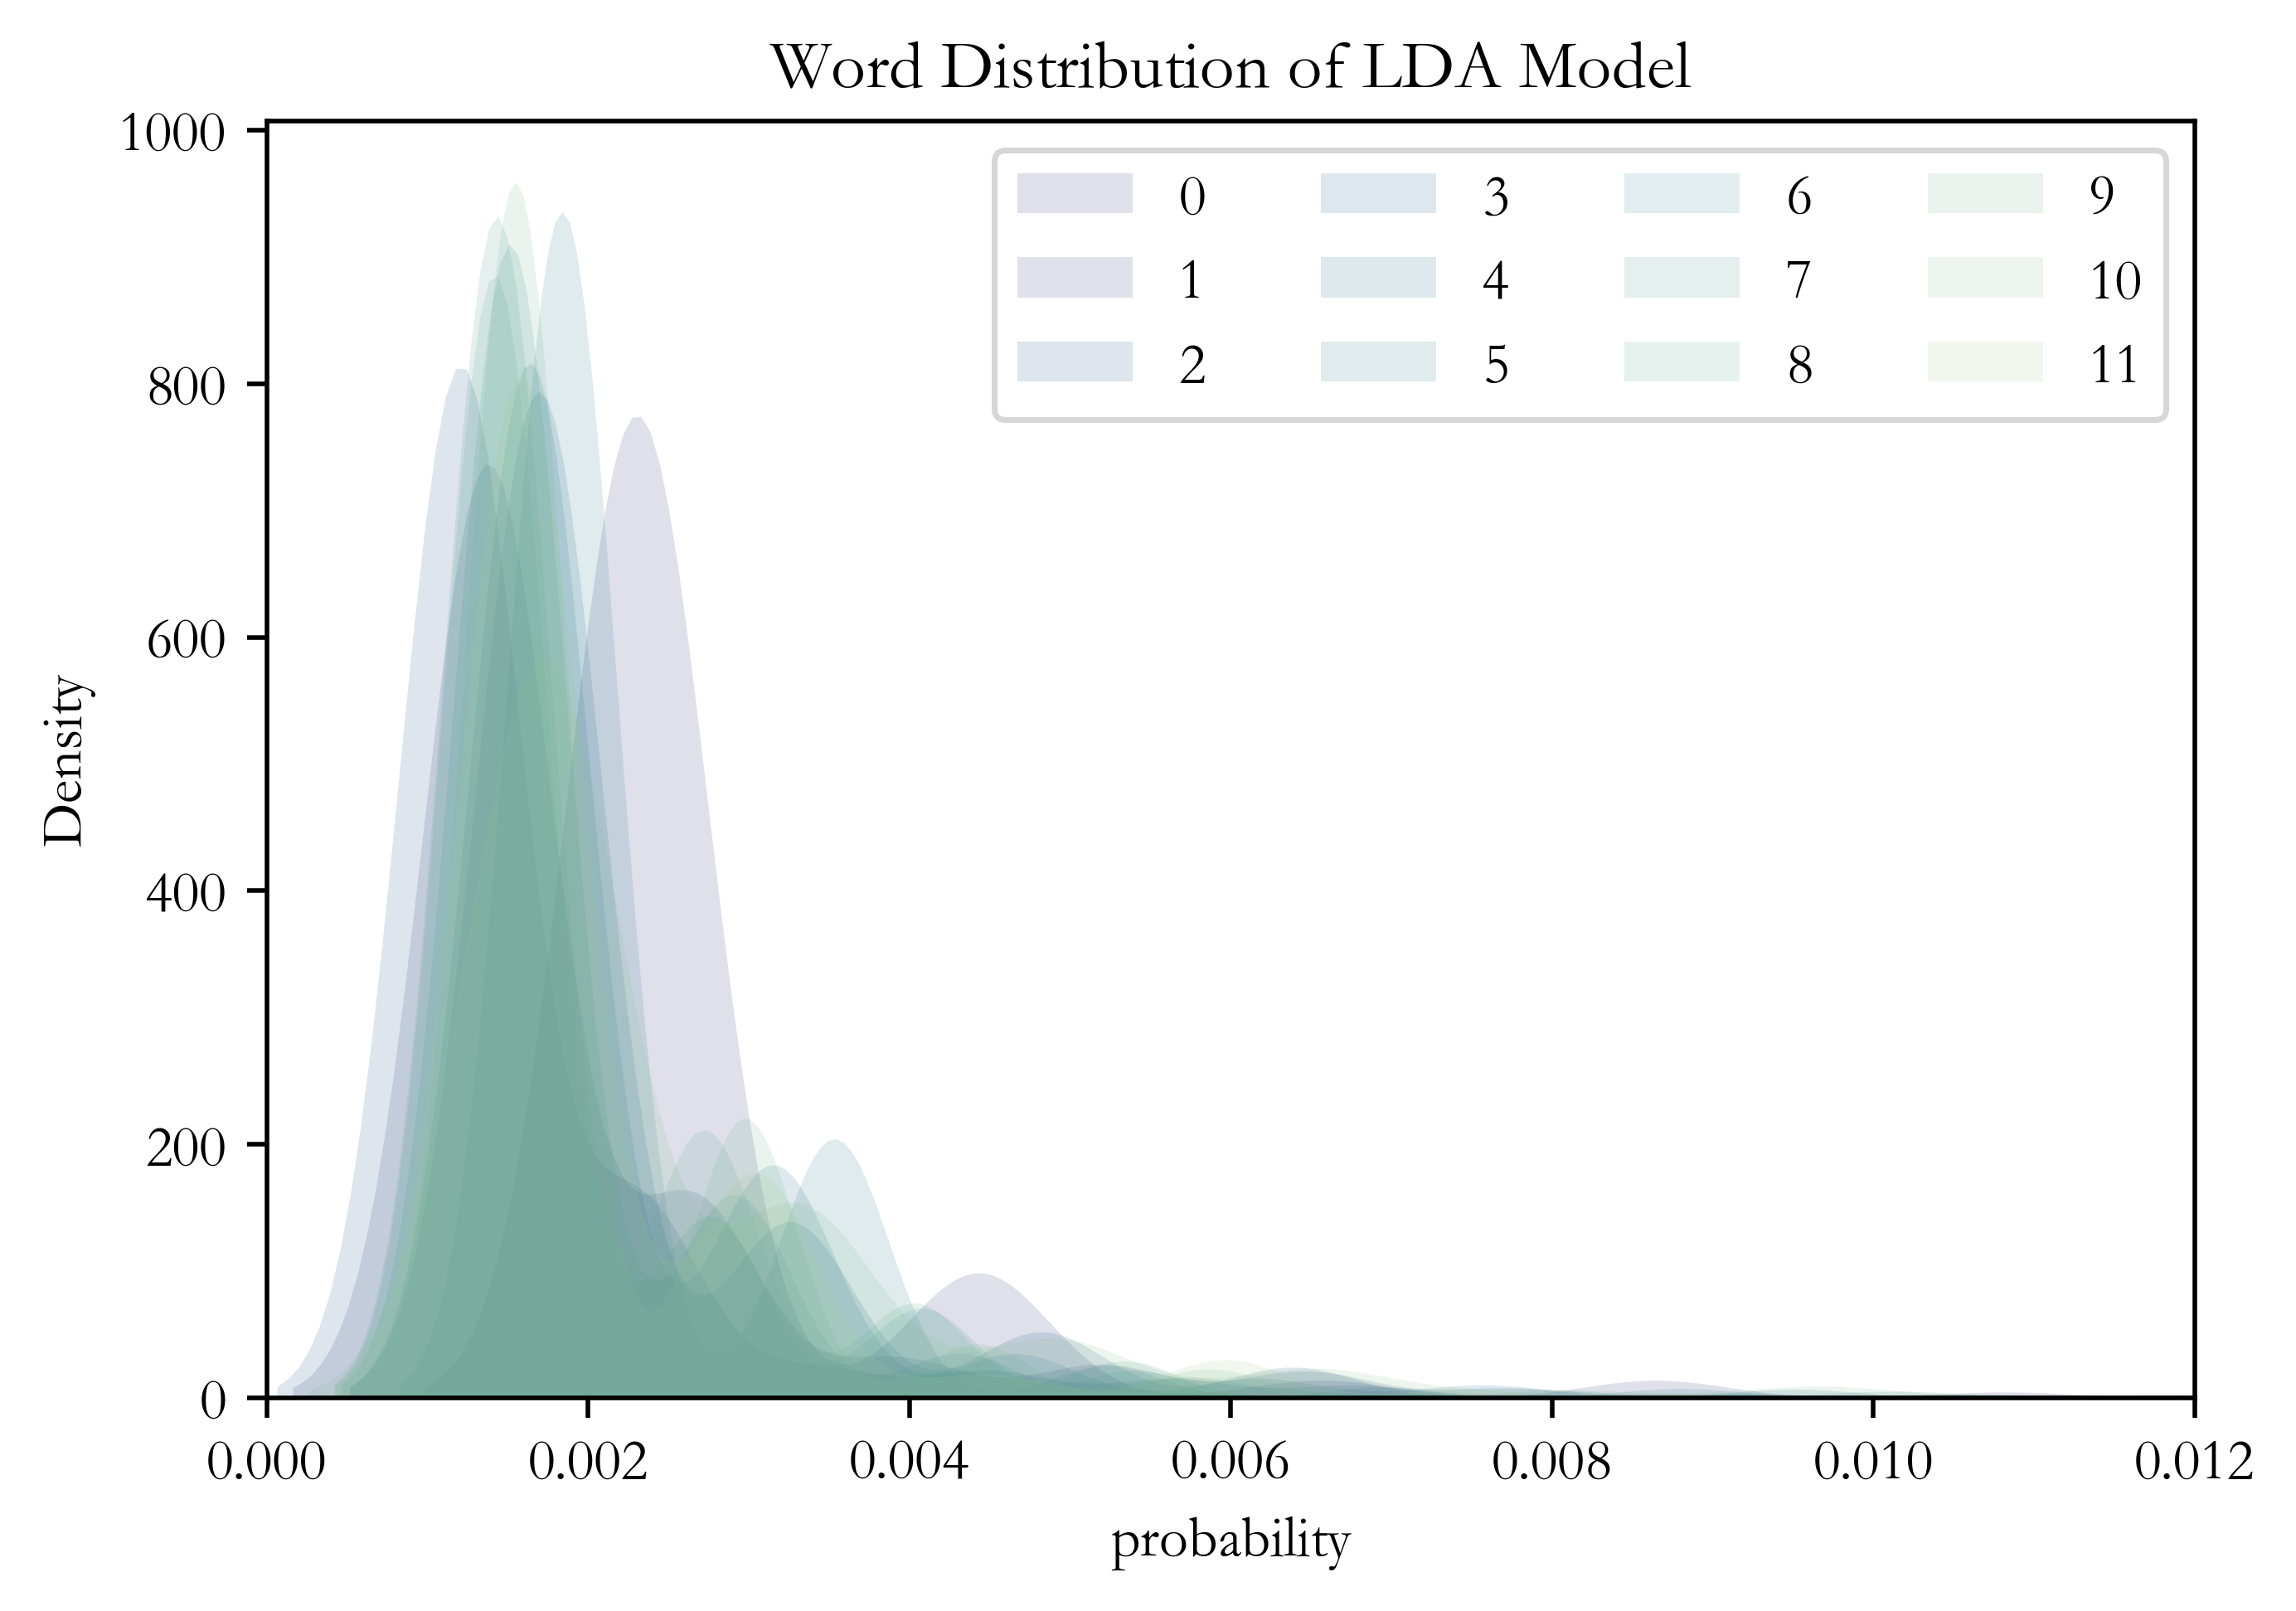

In [44]:
plt.figure(figsize = (6, 4), dpi=500)
word_dist_filter = word_dist[(word_dist['probability'] < 0.012) & (word_dist['probability'] > 0.001)]
sns.kdeplot(data=word_dist_filter,
            x='probability',
            hue='topic',
            fill=True,
            common_norm=False,
            palette='crest',
            alpha=.15,
            linewidth=0)
plt.xlim(0, 0.012)
plt.legend(range(20), ncol=4)
plt.title('Word Distribution of LDA Model')
plt.show()

查看所有谣言中主题的分布，发现比较均匀。

In [45]:
tmp = pd.DataFrame(df.groupby('sub_topic')['content'].count()).reset_index()
tmp

,sub_topic,content
0,0,40
1,1,27
2,2,33
3,3,34
4,4,33
5,5,28
6,6,27
7,7,28
8,8,20
9,9,41


In [46]:
pie = (
    Pie(init_opts=opts.InitOpts(width='960px', height='720px', theme=ThemeType.LIGHT))
    .add('', tmp.values.tolist())
    .set_global_opts(title_opts=opts.TitleOpts(title='文本主题分布'))
    .set_series_opts(label_opts=opts.LabelOpts(formatter='{b}: {d}%'))
)

# 渲染图表
pie.render('LDA/LdaModel_pie_sub.html')
pie.render_notebook()

## 2.5 词云图展示

我们已经用LDA模型计算出了每条谣言对应的topic，现在我们对每个topic画出词云图进行展示。

In [47]:
colorlist = ['Blues', 'BuPu', 'Greens', 'Greys', 'Oranges', 'PuBu', 'PuRd', 
             'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']

In [48]:
def draw_wordcloud(topicid, color='Blues'):
    freq = {dictionary[i]: lda_matrix[topicid][i] for i in range(len(dictionary))}
    stylecloud.gen_stylecloud(
        text=freq,
        font_path="wordcloud/STSong.ttf",
        size = 1000,
        icon_name='fas fa-cloud',
        palette='colorbrewer.sequential.' + color + '_7',
        background_color='white',
        max_words=200,
        stopwords=True,
        custom_stopwords=['例新冠', '发现', '发生', '包', '有人', '一名'],
        collocations=False,
        # gradient='horizontal',
        output_name=f'wordcloud/wordcloud{topicid}.png'
    )
    return Image(filename = f'wordcloud/wordcloud{topicid}.png')

In [49]:
# for tid in range(num_topic):
#     draw_wordcloud(tid, colorlist[tid])

## 2.6 情感分析

对每条谣言计算出情感分数，存入变量emotion。

In [50]:
df['sub_emotion'] = df['core'].apply(lambda x: SnowNLP(x).sentiments)

绘制情感分数直方图，发现靠近0和1的分布最为密集。这说明谣言都带有强烈的情感色彩，要么强烈正向，要么强烈负向。

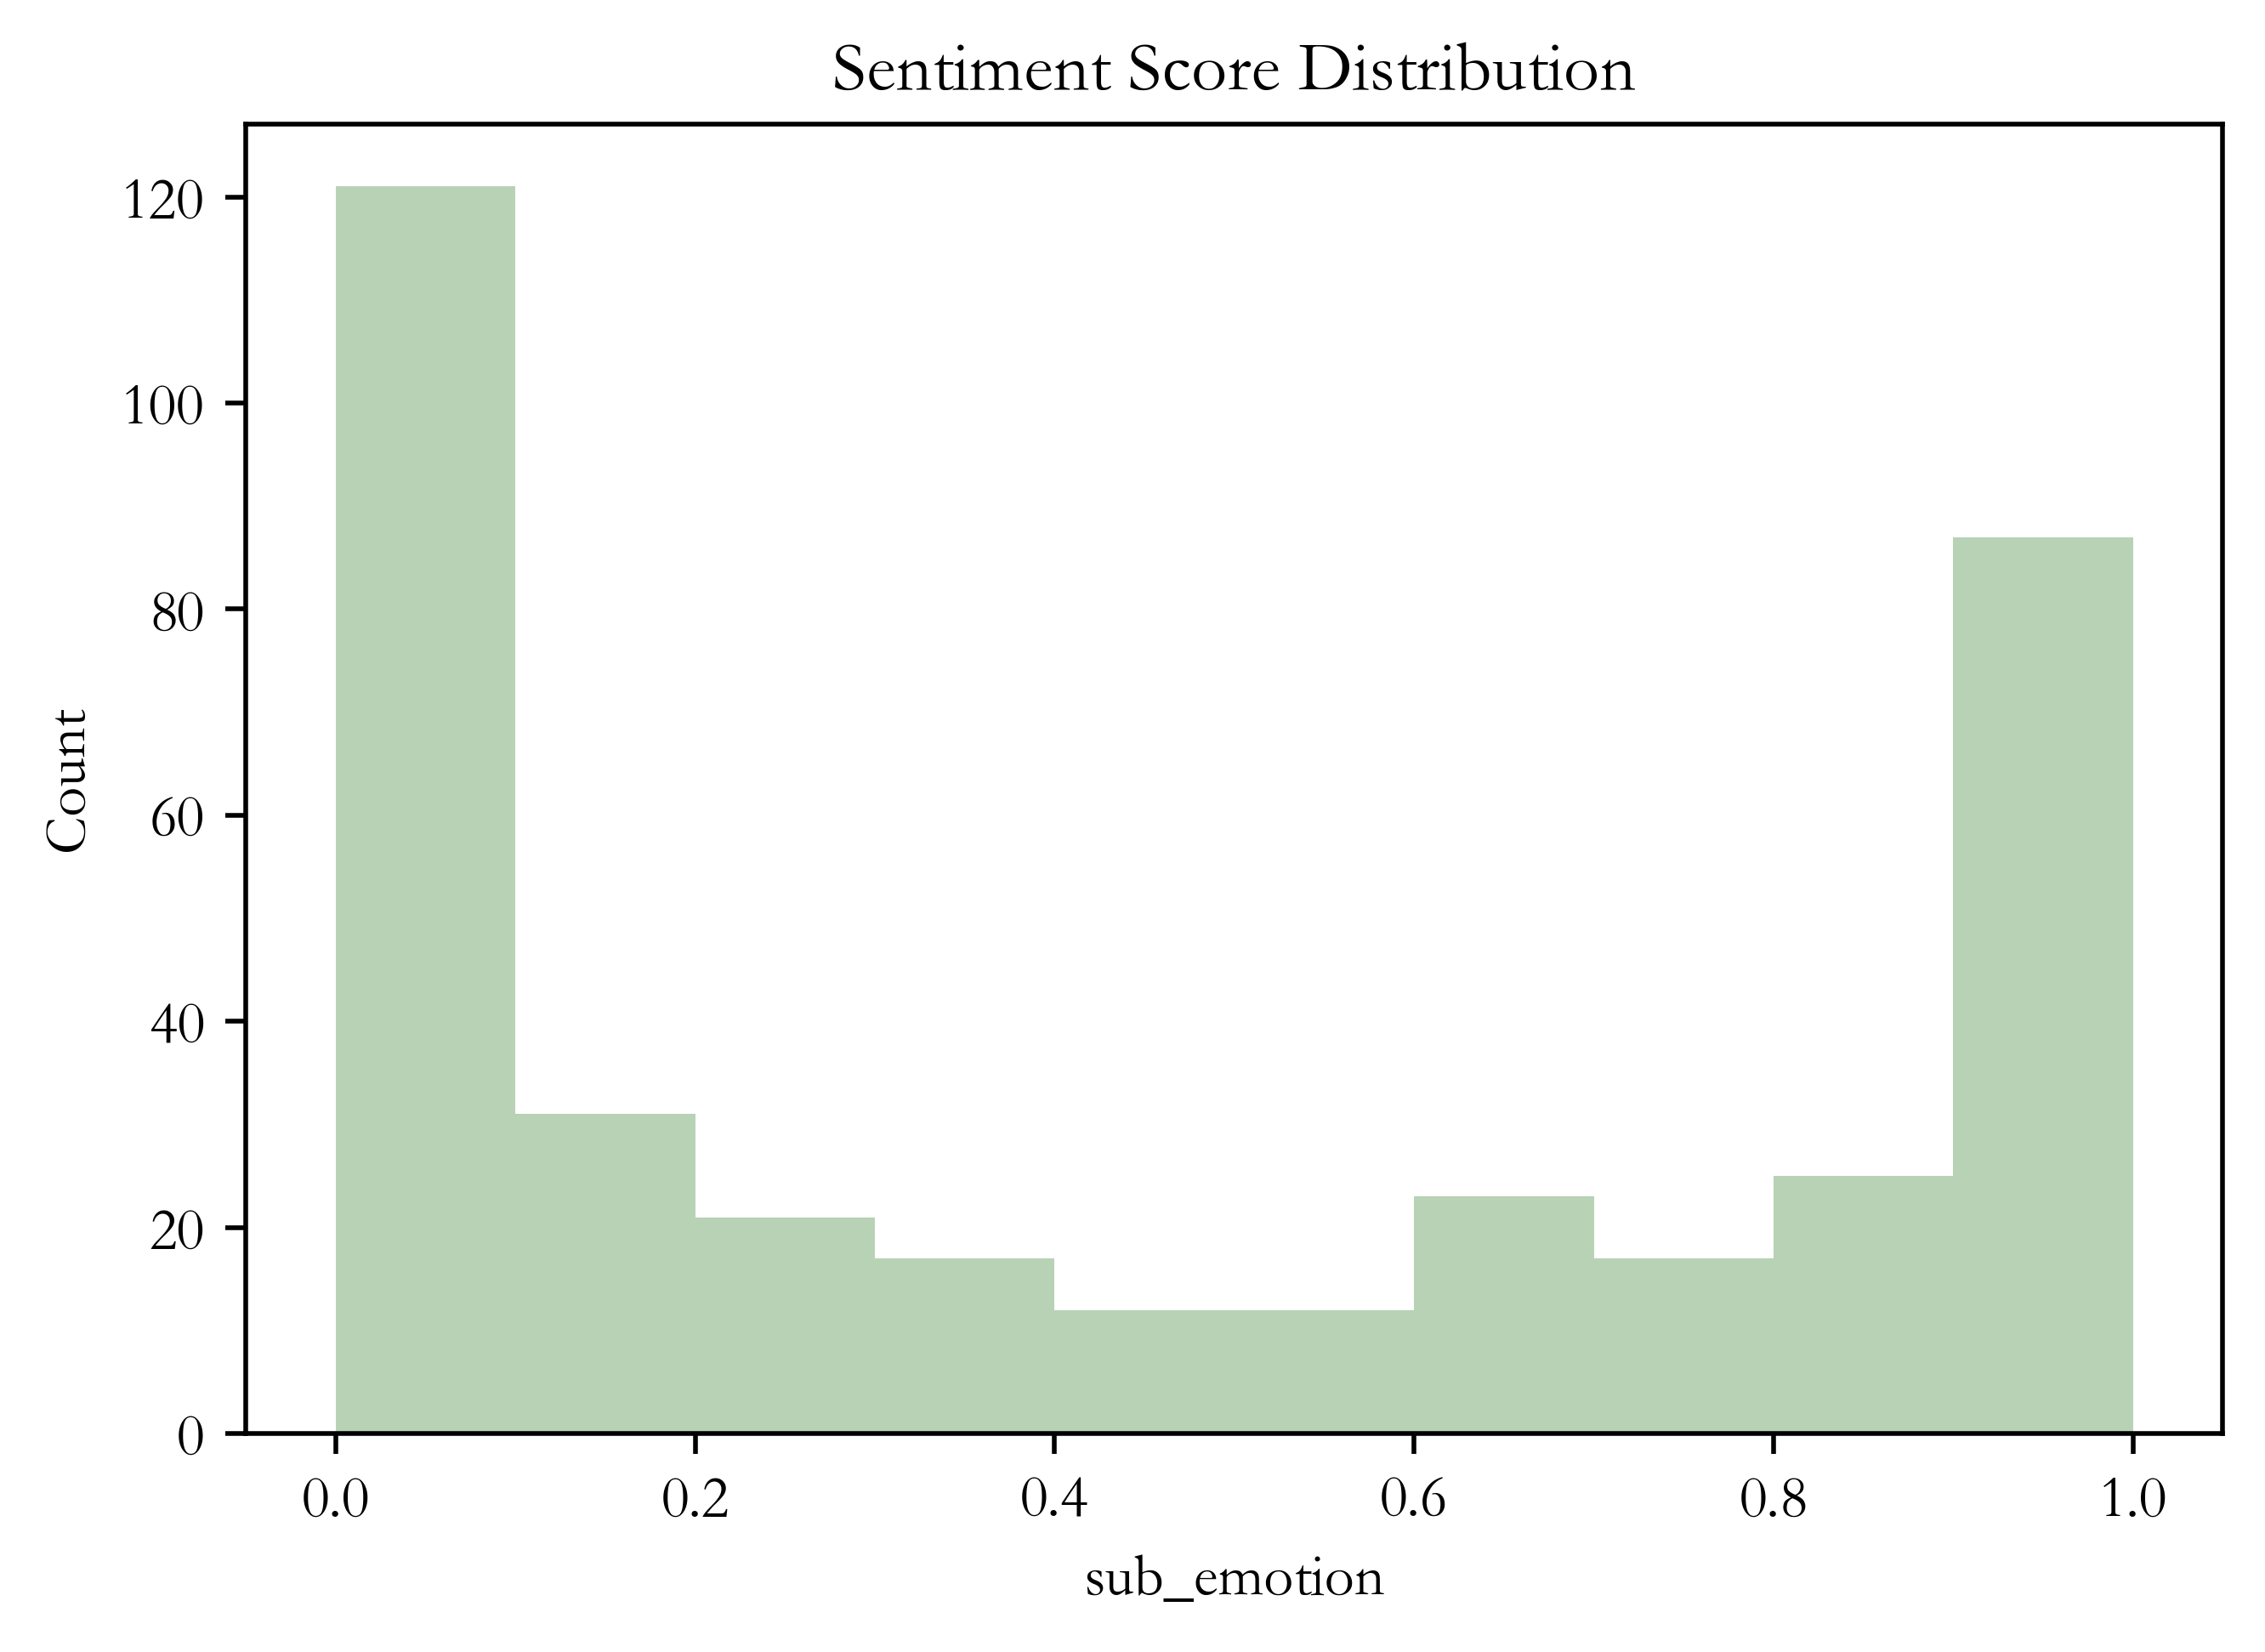

In [51]:
plt.figure(figsize = (6, 4), dpi=500)
sns.histplot(df['sub_emotion'], linewidth=0, color='#A0C49D', binwidth=0.1)
plt.title('Sentiment Score Distribution')
plt.show()

对LDA模型中的每个主题计算情感得分的均值，并画出相应的柱形图，发现：
- 只有Topic 11的情感得分明显正向
- 负向情感的谣言居多
- Topic 4、7、1的情感得分明显负向

In [52]:
tmp = pd.DataFrame(df.groupby('sub_topic')['sub_emotion'].mean() - 0.5).reset_index()
tmp.head()

,sub_topic,sub_emotion
0,0,-0.049865
1,1,-0.122975
2,2,0.015292
3,3,0.022401
4,4,-0.220344


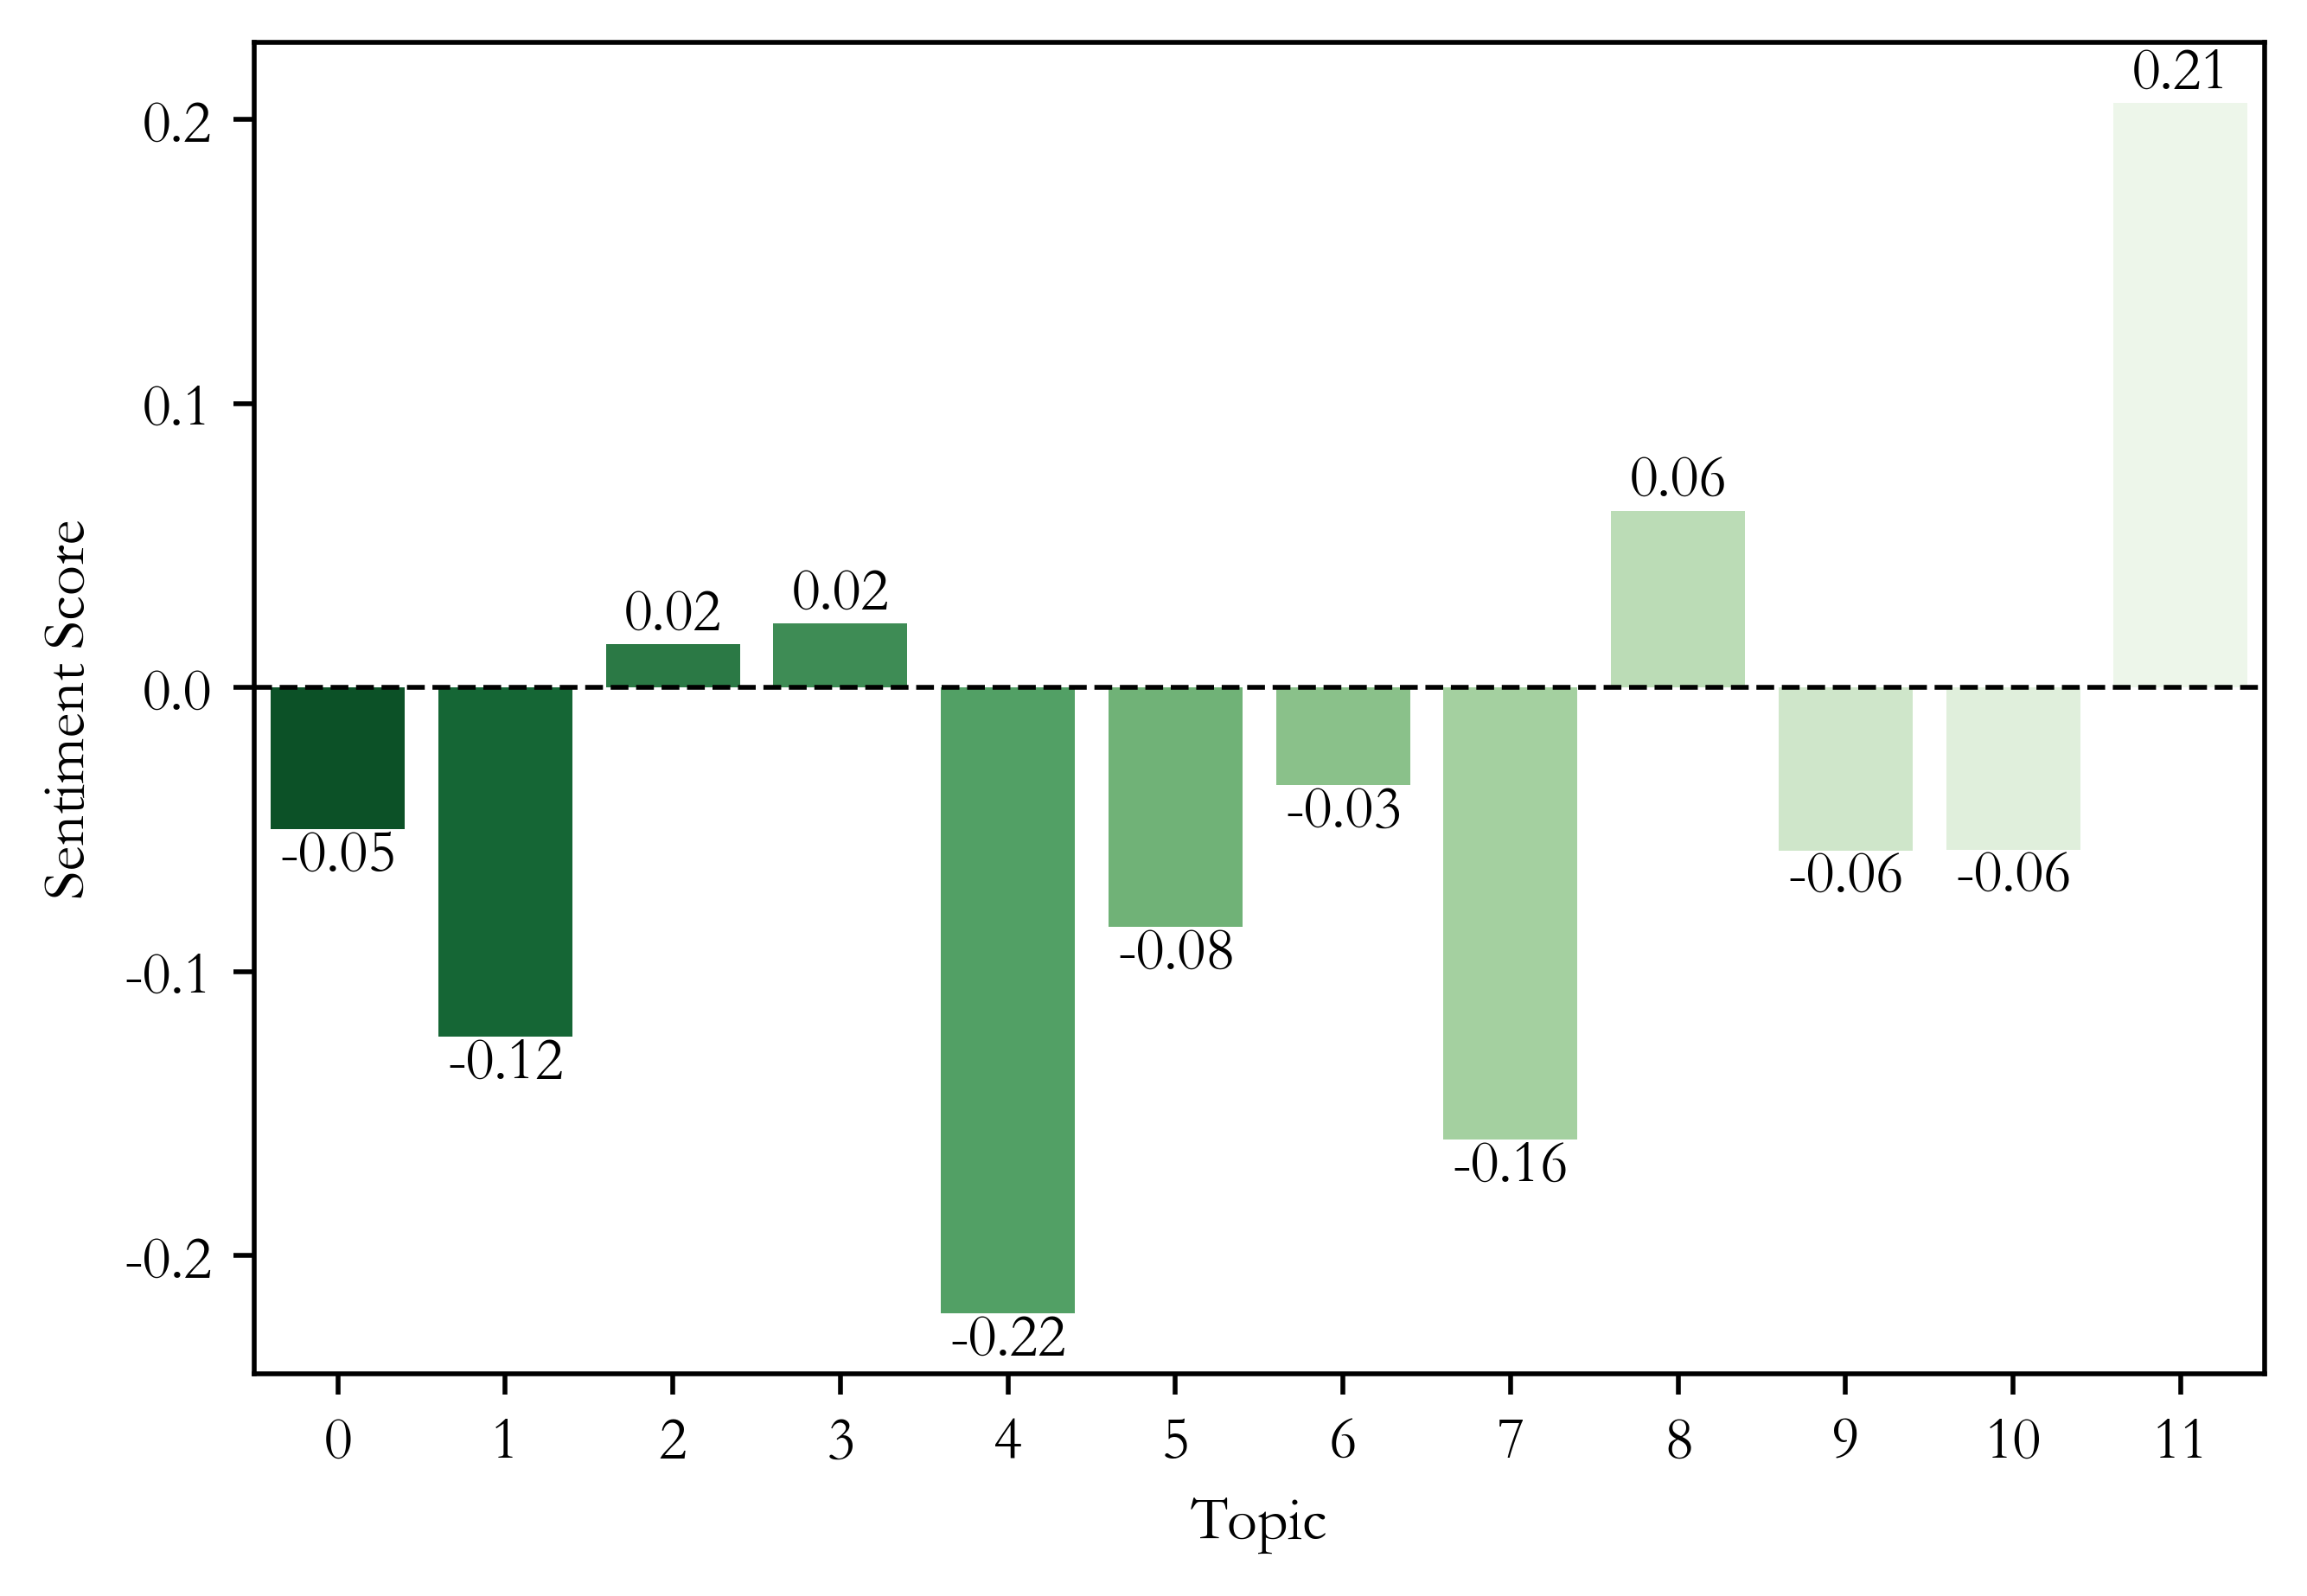

In [53]:
plt.figure(figsize = (6, 4), dpi=500)
plt.rcParams['axes.unicode_minus'] = False
#数据可视化
sns.barplot(y=tmp['sub_emotion'], x=tmp['sub_topic'], palette='Greens_r')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
# plt.title('Sentiment Score by Topic')
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.8)
for a, b in zip(list(tmp['sub_topic']), tmp['sub_emotion']):
    if b < 0:
        va = 'top'
    else:
        va = 'bottom'
    plt.text(a, b, round(b, 2), ha = 'center', va = va, fontsize = 10)
plt.show()

查看情感强烈程度。

In [54]:
df['abs_sub_emotion'] = np.abs(df['sub_emotion'] - 0.5)
tmp = pd.DataFrame(df.groupby('sub_topic')['abs_sub_emotion'].mean()).reset_index()
tmp.head()

,sub_topic,abs_sub_emotion
0,0,0.344874
1,1,0.405317
2,2,0.373619
3,3,0.375526
4,4,0.423031


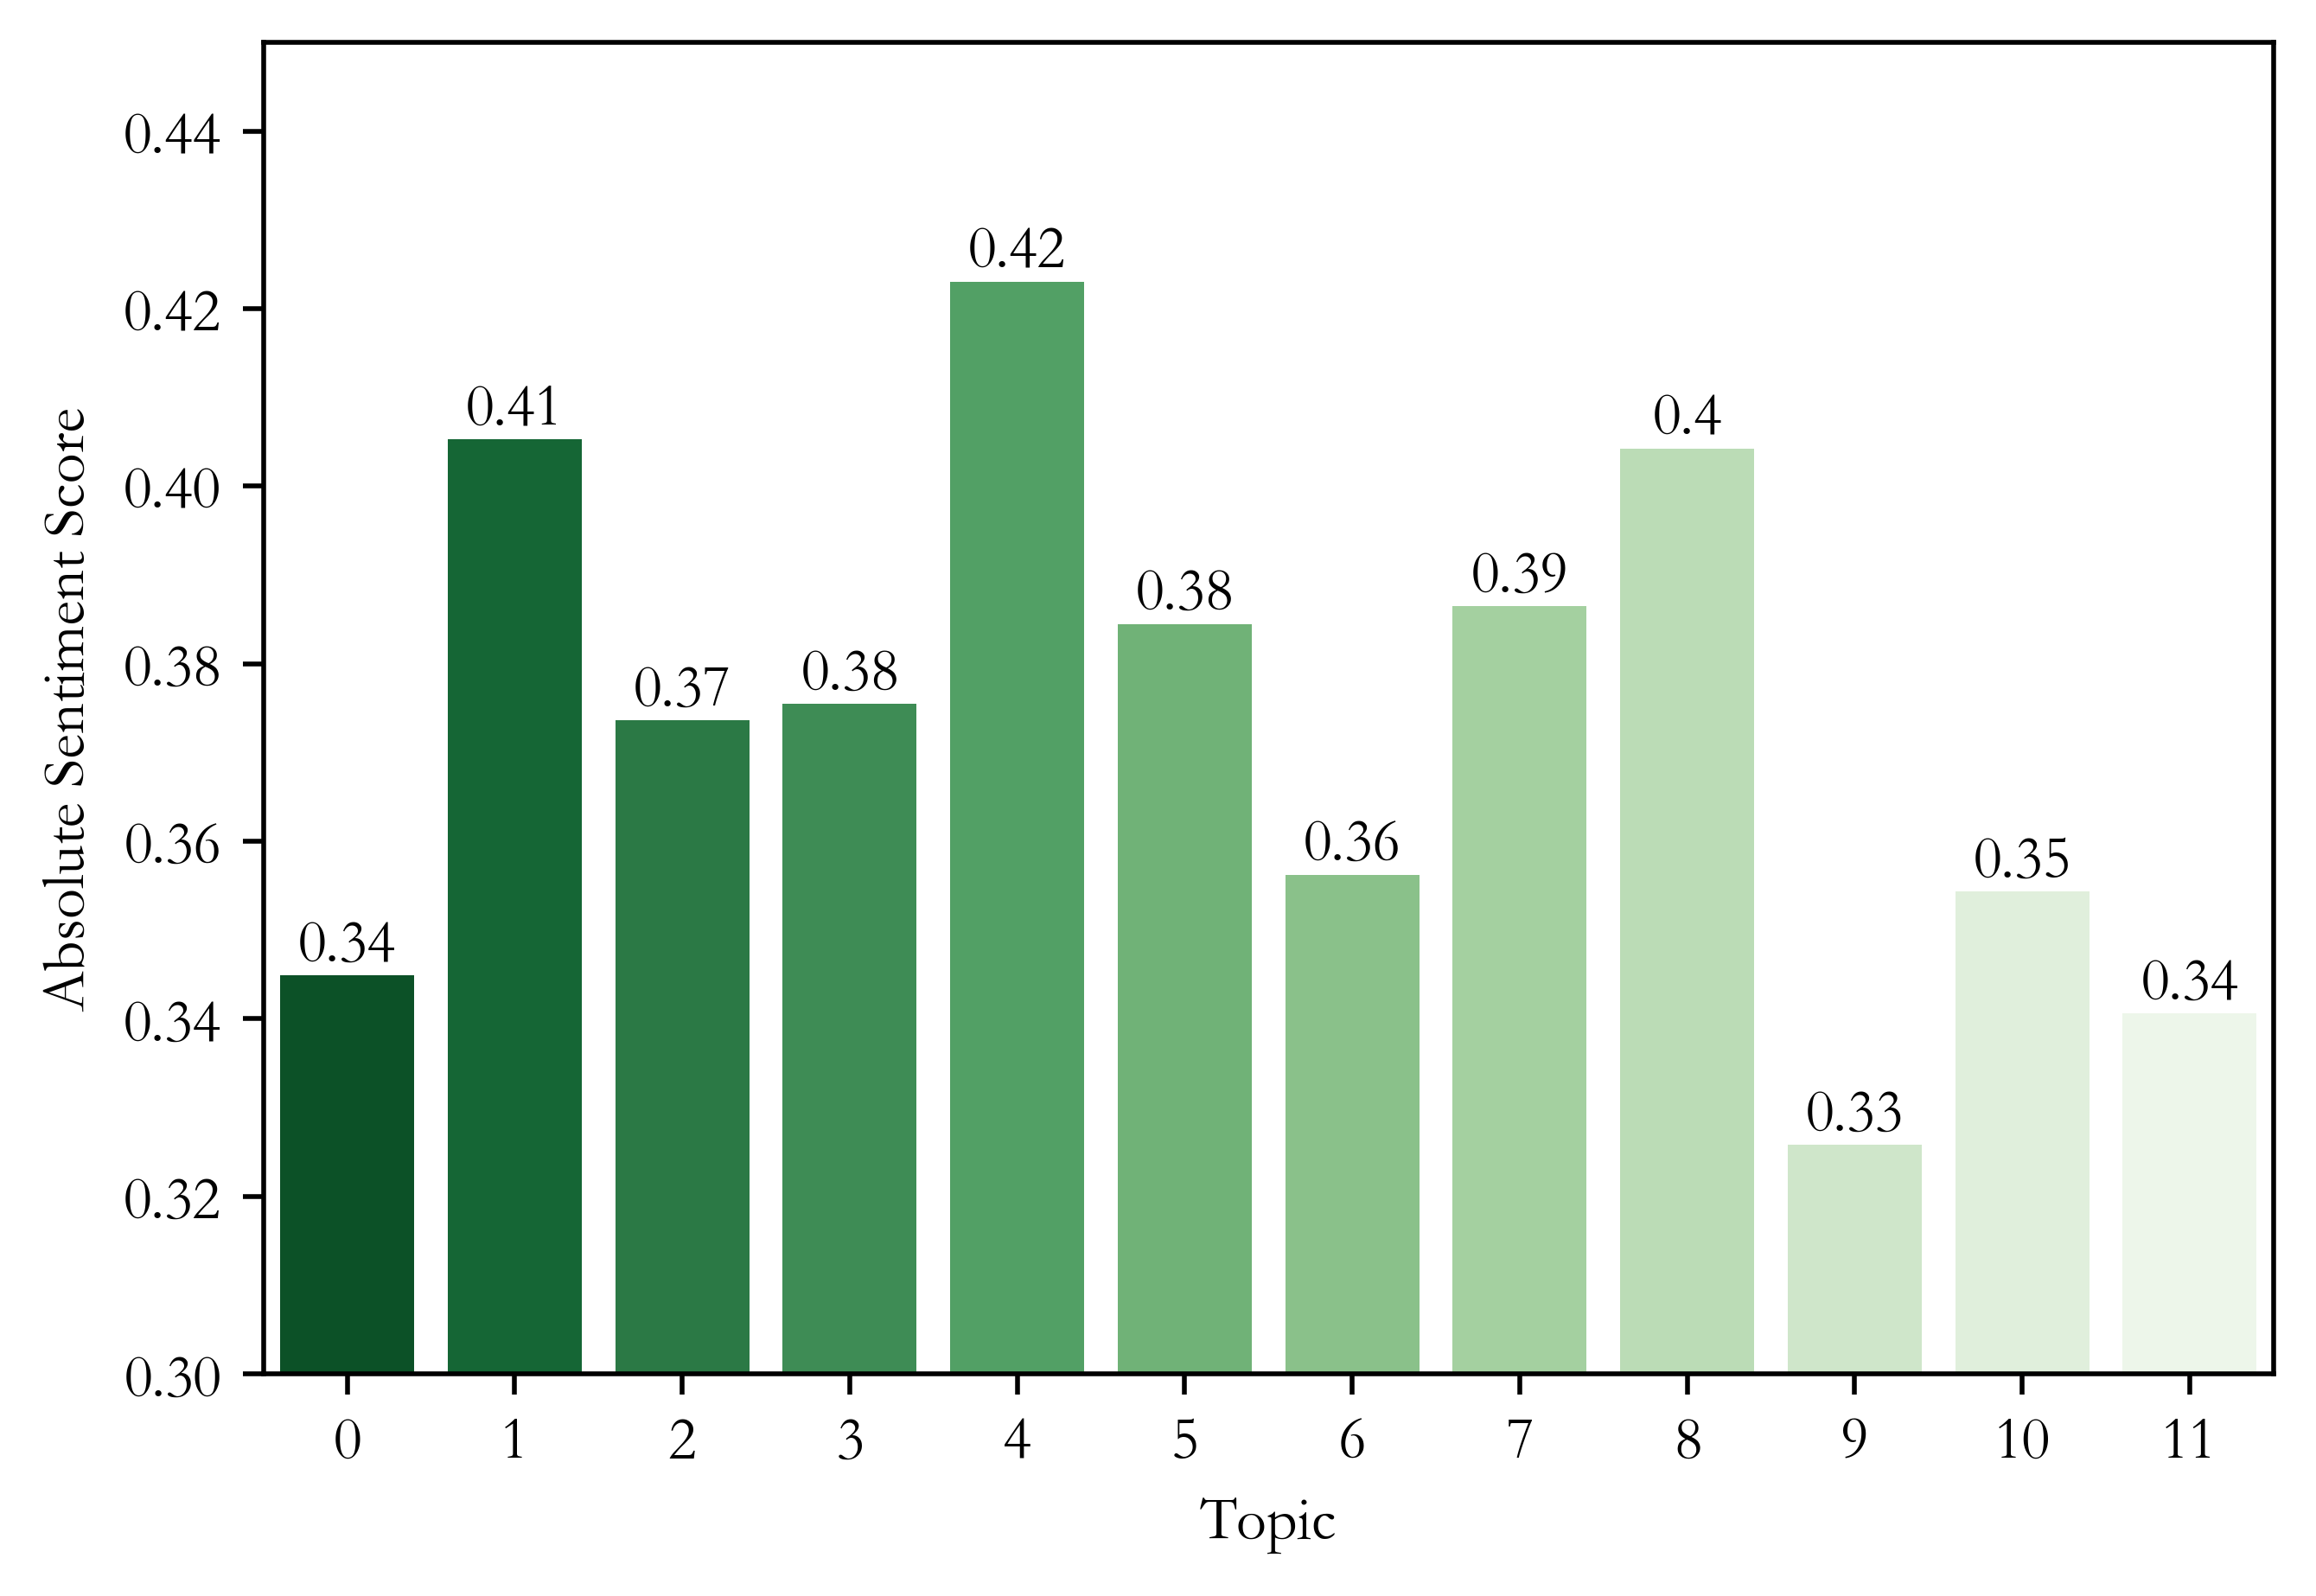

In [55]:
plt.figure(figsize = (6, 4), dpi=500)
plt.rcParams['axes.unicode_minus'] = False
#数据可视化
sns.barplot(y=tmp['abs_sub_emotion'], x=tmp['sub_topic'], palette='Greens_r')
plt.xlabel('Topic')
plt.ylabel('Absolute Sentiment Score')
# plt.title('Sentiment Score by Topic')
plt.axhline(0, color='black', linestyle='dashed', linewidth=0.8)
for a, b in zip(list(tmp['sub_topic']), tmp['abs_sub_emotion']):
    if b < 0:
        va = 'top'
    else:
        va = 'bottom'
    plt.text(a, b, round(b, 2), ha = 'center', va = va, fontsize = 10)
plt.ylim(0.3, 0.45)
plt.show()

保存数据到本地。

In [56]:
df.to_csv('data/rumor_text_data_processed.csv', index=False)

## 2.7 大小标题的包含关系

大小标题的包含关系如下：
- 0: 0, 7, 11
- 1: 3, 4, 6
- 2: 9, 2
- 3: 5, 8
- 4: 10
- 5: 1

In [57]:
tmp = df.groupby(['all_topic', 'sub_topic'])['content'].count(
).reset_index().sort_values(['all_topic','content'], ascending=False
                           )
tmp[tmp.content >= 6].head()

,all_topic,sub_topic,content
58,5,1,6
60,5,3,6
56,4,10,6
41,3,5,8
36,3,0,7
